In [1]:
import pandas as pd
import konlpy
from konlpy.tag import Komoran
from konlpy.tag import Okt
from pprint import pprint
from collections import defaultdict
from collections import Counter
import warnings # 경고 알림 제거
print(konlpy.__version__)
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook # progress bar
#from konlpy.tag import Mecab #Mecab, Okt 등 형태소 분석기 불러오기,앞에서 코모란불러옴 
import numpy as np
import string # 특수문자
from gensim import corpora
from gensim import models
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) # 경고 알림이 뜨면 모두 무시

0.6.0


In [2]:
okt=Okt()

In [3]:
data = pd.read_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/kakao_review_scroll120.csv')

In [4]:
data.head(5)

,날짜,리뷰,별점,month
0,2023년 10월 18일,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...,1,2023년
1,2023년 10월 17일,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...,1,2023년
2,2023년 8월 9일,늘 잘사용하고있어요 z플립5 외부화면에서 사용시 네이버페이는 문제없이 편하게 결제동...,5,2023년
3,2023년 7월 3일,"렉,버퍼링 겁나 느리고 화면 안뜸현상 짜증나요ㅠㅠ 주식은 타이밍이 전부인데... 특...",1,2023년
4,2023년 6월 9일,"자주 쓰는 서비스는 앞으로 꺼내고 --> 나에게 맞게 설정해 놓고 잘 쓰고 있는데,...",1,2023년


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      3000 non-null   object
 1   리뷰      3000 non-null   object
 2   별점      3000 non-null   int64 
 3   month   3000 non-null   object
dtypes: int64(1), object(3)
memory usage: 93.9+ KB


In [6]:
# 결측치 확인
data.isnull().sum()

날짜       0
리뷰       0
별점       0
month    0
dtype: int64

In [7]:
# 전처리 함수

import re 

def clean_text(text):    
    
    pattern='(\[a-zA-Z0-9\_.+-\]+@\[a-zA-Z0-9]+.\[a-zA-Z0-9-.\]+)' # email제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    text = text.upper()
    
    pattern = '([ㄱ-ㅎㅏ-ㅣ])+' # 한글 자음, 모음 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern=re.compile(r'([^\w]?\d+\.?\,?\)?\d*)+') # 숫자 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern='<[^>]*>' # html 태그 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern='[\r|\n]' # \r,\n 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern= '[^\w\s]' # 특수기호 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern=re.compile(r'\s+')  #  이중 space 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)

#     hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글과 띄어쓰기를 제외한 모든 글자
#     text=re.sub(pattern=hangul,repl=' ',string=text) # 한글과 띄어쓰기를 제외한 모든 부분을 제거
    
    text=text.strip()
    return text

In [8]:
data['리뷰1'] = data['리뷰'].apply(clean_text)

In [9]:
data.head(5)

,날짜,리뷰,별점,month,리뷰1
0,2023년 10월 18일,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...,1,2023년,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...
1,2023년 10월 17일,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...,1,2023년,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...
2,2023년 8월 9일,늘 잘사용하고있어요 z플립5 외부화면에서 사용시 네이버페이는 문제없이 편하게 결제동...,5,2023년,늘 잘사용하고있어요 Z플립 외부화면에서 사용시 네이버페이는 문제없이 편하게 결제동작...
3,2023년 7월 3일,"렉,버퍼링 겁나 느리고 화면 안뜸현상 짜증나요ㅠㅠ 주식은 타이밍이 전부인데... 특...",1,2023년,렉 버퍼링 겁나 느리고 화면 안뜸현상 짜증나요 주식은 타이밍이 전부인데 특히 미국주...
4,2023년 6월 9일,"자주 쓰는 서비스는 앞으로 꺼내고 --> 나에게 맞게 설정해 놓고 잘 쓰고 있는데,...",1,2023년,자주 쓰는 서비스는 앞으로 꺼내고 나에게 맞게 설정해 놓고 잘 쓰고 있는데 불편한 ...


In [10]:
#불용어 생성

SW = ['카카오','페이','카카오페이','사용','카카오톡','토스','네이버','카톡','이용','가요','때문','하나','무슨','다시','어쩌',
      '해도','무슨','일시','혹시','기능','이제','하라','다른','경우','갑자기','보기','지금','이해','정말','진짜','그냥','예전',
      '아예','안나','자꾸','몇번','한번','자체','건가','워치','뱅크','은행','확인','어가','해주','어요','어서','려고','이유','도대체','아무',
      '하니','다가','계속','면서','가능','주시','려니','라면','자산','삭제','잔액','추가','까지','하나요','어디','먼저','지도','시도','더니']



In [11]:

from ckonlpy.tag import Twitter
twitter = Twitter()

c:\Users\junbong heo\AppData\Local\Programs\Python\Python311\Lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [12]:
twitter.add_dictionary('주민등록증', 'Noun')
twitter.add_dictionary('결제오류', 'Noun')
twitter.add_dictionary('카드결제', 'Noun')
twitter.add_dictionary('설치 오류', 'Noun')
twitter.add_dictionary('본인인증', 'Noun')
twitter.add_dictionary('연결상태', 'Noun')
twitter.add_dictionary('휴대폰인증', 'Noun')
twitter.add_dictionary('주식창', 'Noun')
twitter.add_dictionary('주민등록번호', 'Noun')
twitter.add_dictionary('인증번호', 'Noun')
twitter.add_dictionary('계좌연결','Noun')
twitter.add_dictionary('계좌번호','Noun')
twitter.add_dictionary('소리 알림','Noun')
twitter.add_dictionary('주식 알림','Noun')


In [13]:
import pickle

In [14]:


def read_documents(input_file_name):
    """문서들을 주어진 이름의 파일로부터 읽어들여 돌려준다."""
    corpus = []
    with open(input_file_name, 'rb') as f:
        temp_corpus = pickle.load(f)
    for page in temp_corpus:
        corpus += page
    return corpus

def text_tokenizing(corpus, tokenizer):
    token_corpus = []

    if tokenizer == "noun":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = twitter.nouns(corpus[n])
            token_text = [word for word in token_text if word == '렉'  or (word not in SW and len(word) > 1)]
            token_corpus.append(token_text)

    elif tokenizer == "morph":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = twitter.morphs(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

    elif tokenizer == "word":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = corpus[n].split()
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

        
    return token_corpus

In [15]:
import ipywidgets

In [16]:
data

,날짜,리뷰,별점,month,리뷰1
0,2023년 10월 18일,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...,1,2023년,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...
1,2023년 10월 17일,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...,1,2023년,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...
2,2023년 8월 9일,늘 잘사용하고있어요 z플립5 외부화면에서 사용시 네이버페이는 문제없이 편하게 결제동...,5,2023년,늘 잘사용하고있어요 Z플립 외부화면에서 사용시 네이버페이는 문제없이 편하게 결제동작...
3,2023년 7월 3일,"렉,버퍼링 겁나 느리고 화면 안뜸현상 짜증나요ㅠㅠ 주식은 타이밍이 전부인데... 특...",1,2023년,렉 버퍼링 겁나 느리고 화면 안뜸현상 짜증나요 주식은 타이밍이 전부인데 특히 미국주...
4,2023년 6월 9일,"자주 쓰는 서비스는 앞으로 꺼내고 --> 나에게 맞게 설정해 놓고 잘 쓰고 있는데,...",1,2023년,자주 쓰는 서비스는 앞으로 꺼내고 나에게 맞게 설정해 놓고 잘 쓰고 있는데 불편한 ...
...,...,...,...,...,...
2995,2019년 6월 24일,본인확인 과정에서 자꾸 본인확인이아니라고해답답하세요,2,2019년,본인확인 과정에서 자꾸 본인확인이아니라고해답답하세요
2996,2021년 5월 28일,리뷰 왜 삭제하십니까? 남혐논란 문의하고 그 담당 직원 징계 문의하면 답변을 줘야지...,1,2021년,리뷰 왜 삭제하십니까 남혐논란 문의하고 그 담당 직원 징계 문의하면 답변을 줘야지 ...
2997,2023년 9월 23일,렉 걸리는거 절대 안고치네...ㄷㄷ,1,2023년,렉 걸리는거 절대 안고치네
2998,2021년 2월 22일,잘 사용하고있습니다,5,2021년,잘 사용하고있습니다


In [17]:
data['리뷰2'] = text_tokenizing(data['리뷰1'], tokenizer="noun")

Preprocessing:   0%|          | 0/3000 [00:00<?, ?it/s]

In [18]:
data.head(5)

,날짜,리뷰,별점,month,리뷰1,리뷰2
0,2023년 10월 18일,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...,1,2023년,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...,"[업뎃, 이후, 위젯, 먹통, 지우, 위젯, 등록, 잠깐, 시간, 지나, 위젯, 먹..."
1,2023년 10월 17일,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...,1,2023년,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...,"[송금, 화면, 숫자, 지우, 현상, 시적, 현상]"
2,2023년 8월 9일,늘 잘사용하고있어요 z플립5 외부화면에서 사용시 네이버페이는 문제없이 편하게 결제동...,5,2023년,늘 잘사용하고있어요 Z플립 외부화면에서 사용시 네이버페이는 문제없이 편하게 결제동작...,"[플립, 외부, 화면, 문제, 결제, 동작, 수행, 화면, 바코드, 클릭, 부분, 개선]"
3,2023년 7월 3일,"렉,버퍼링 겁나 느리고 화면 안뜸현상 짜증나요ㅠㅠ 주식은 타이밍이 전부인데... 특...",1,2023년,렉 버퍼링 겁나 느리고 화면 안뜸현상 짜증나요 주식은 타이밍이 전부인데 특히 미국주...,"[렉, 버퍼링, 화면, 현상, 짜증, 주식, 타이밍, 전부, 미국, 주식창, 메뉴얼..."
4,2023년 6월 9일,"자주 쓰는 서비스는 앞으로 꺼내고 --> 나에게 맞게 설정해 놓고 잘 쓰고 있는데,...",1,2023년,자주 쓰는 서비스는 앞으로 꺼내고 나에게 맞게 설정해 놓고 잘 쓰고 있는데 불편한 ...,"[자주, 서비스, 설정, 불편, 화면, 설정, 카드, 결제, 도록, 결제, 카드, ..."


In [19]:
data3=data[['날짜','month']].groupby('month').count().reset_index()

data3.columns=['year','count']
data3

,year,count
0,2019년,220
1,2020년,499
2,2021년,1033
3,2022년,638
4,2023년,610


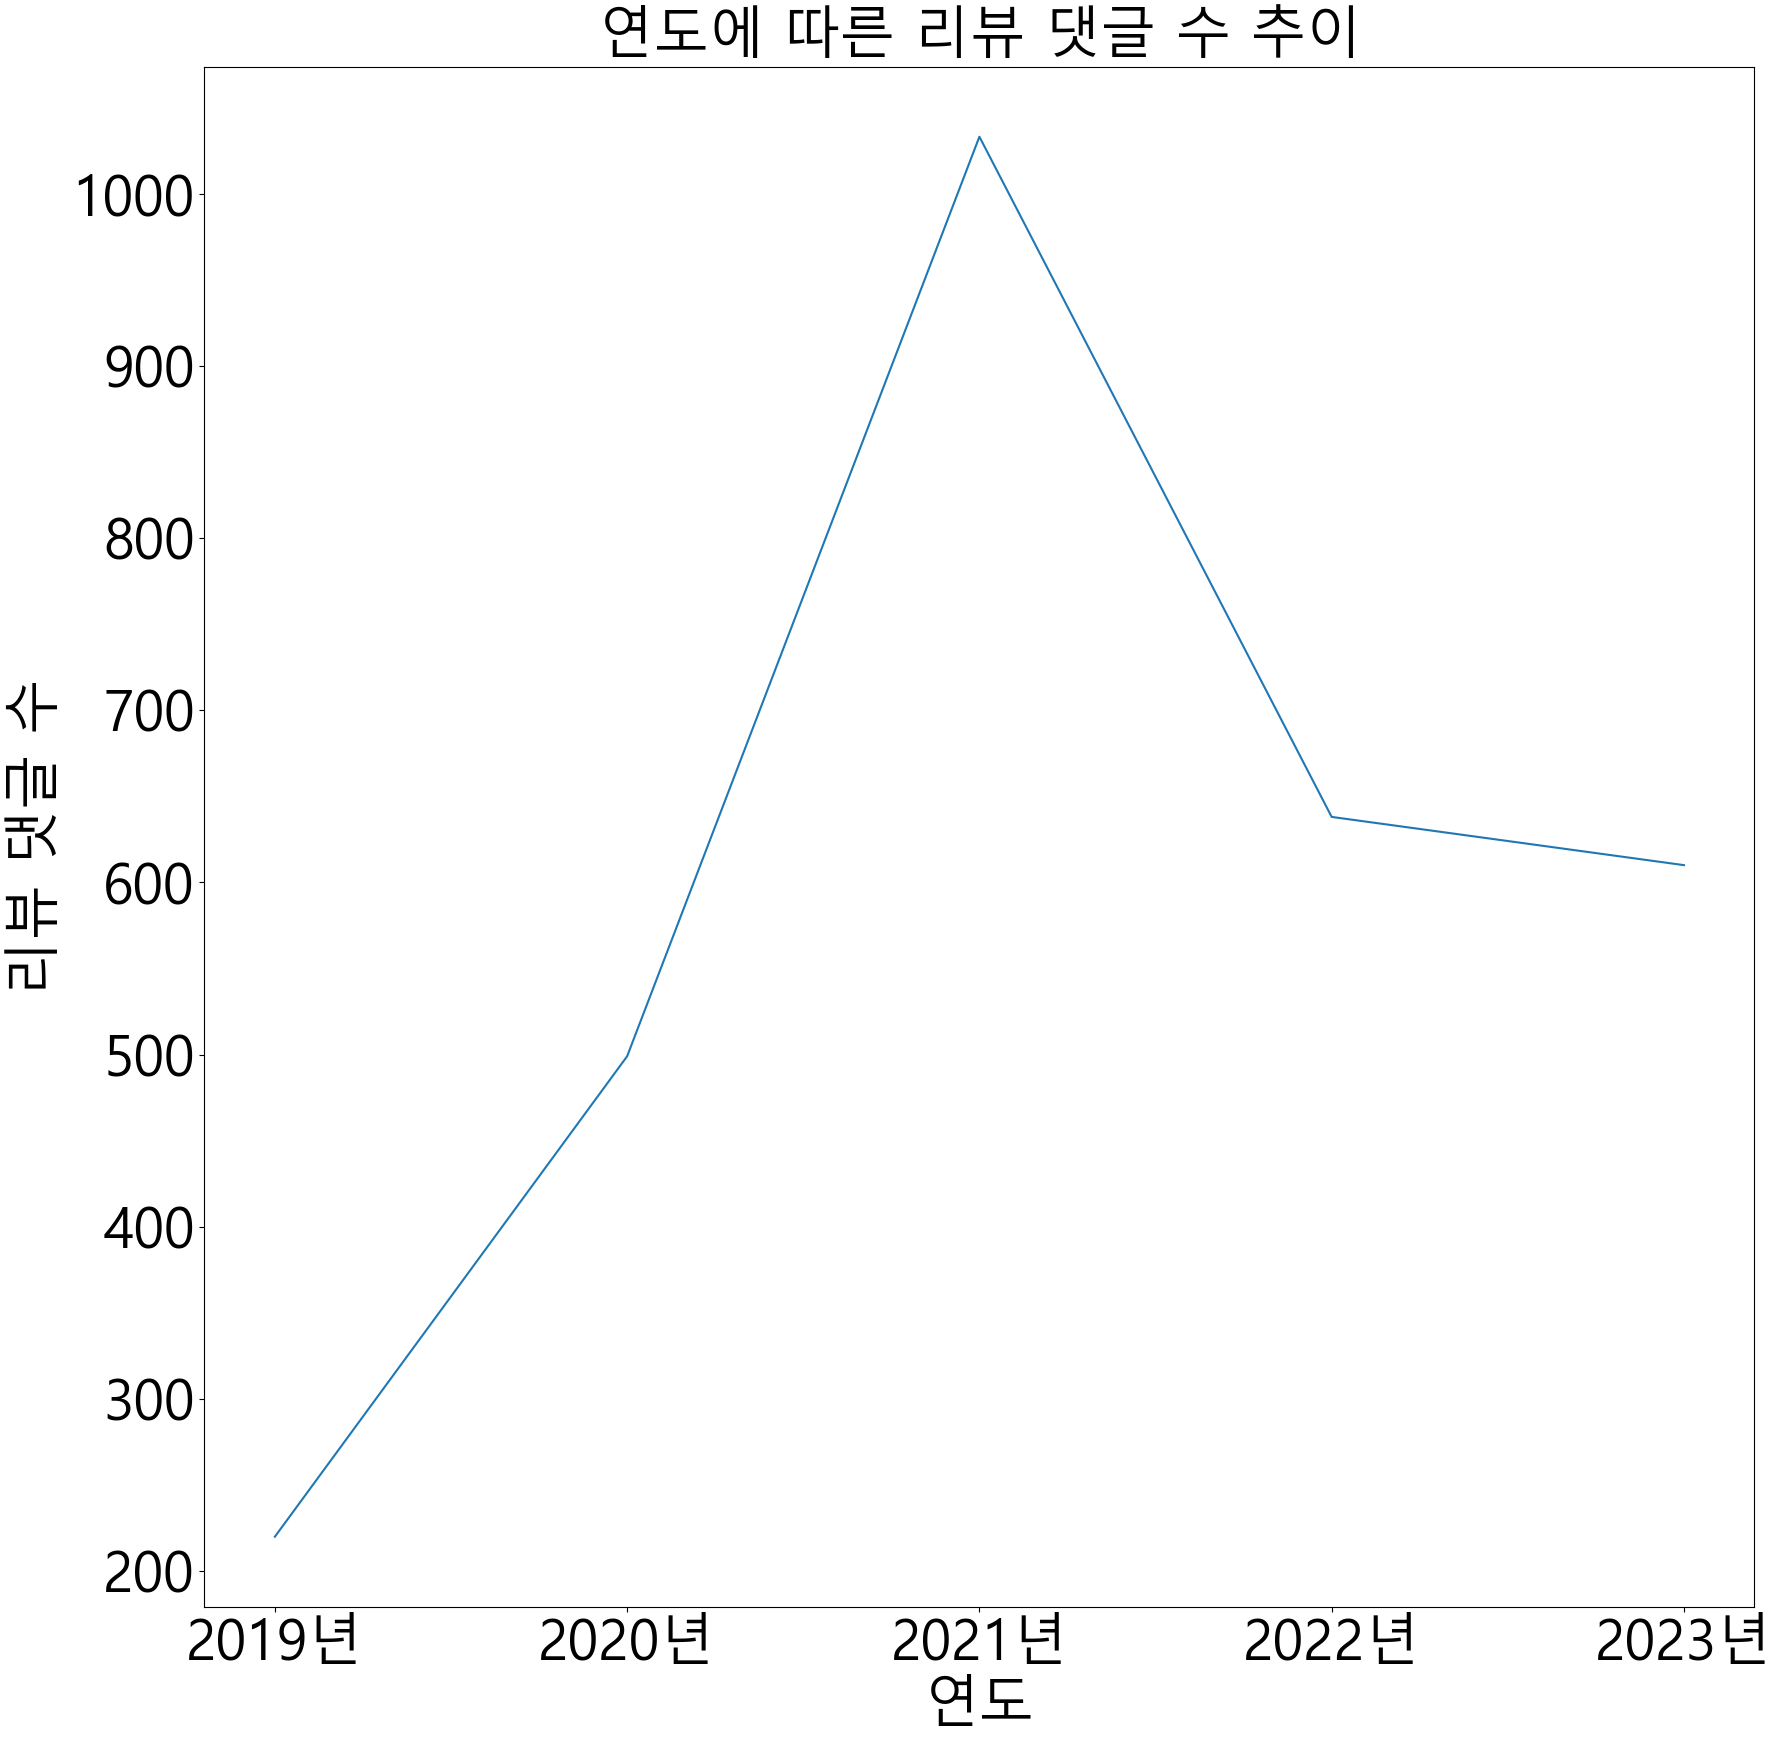

In [20]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_location = 'C:/Windows/Fonts/malgun.ttf'  #font 경로 설정
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
plt.figure(figsize=(20,20))
plt.plot(data3['year'],data3['count'])
plt.title('연도에 따른 리뷰 댓글 수 추이',fontsize=40)
plt.xlabel('연도',fontsize=40)
plt.xticks(fontsize=40)
plt.ylabel('리뷰 댓글 수',fontsize=40)
plt.yticks(fontsize=40)
plt.show()

In [21]:
# 명사 추출 후 해당 단어가 있는지 확인

[x for x in data['리뷰2'] if '지연' in x]

[['최근',
  '차례',
  '제하',
  '연결',
  '지연',
  '메시지',
  '바로가기',
  '클릭',
  '깜박',
  '거리',
  '현상',
  '나타',
  '결과',
  '결제',
  '수도',
  '반복',
  '반복',
  '상태',
  '매우',
  '불편',
  '부탁',
  '드립'],
 ['업데이트', '지연', '무도', '쓰기', '오늘', '게로', '업데이트', '중이', '할런'],
 ['결제',
  '워드',
  '서비스',
  '이동',
  '화면',
  '깜빡',
  '이동',
  '깜빡',
  '화면',
  '이건',
  '대체',
  '결제',
  '워드',
  '초반',
  '사이',
  '아래',
  '이동',
  '지연',
  '가기',
  '화면',
  '깜빡',
  '여서',
  '기분',
  '쁘네']]

In [22]:
data.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/kakao_datafile/kakao_preprocessing.csv', index=None, encoding='utf-8')

In [23]:
data_2021=data[data['month']=='2021년']
data_2022=data[data['month']=='2022년']
data_2023=data[data['month']=='2023년']

data3=pd.concat([data_2021,data_2022,data_2023],axis=0)


In [24]:
data3.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/kakao_datafile/kakao_preprocessing_2021_2023.csv', index=None, encoding='utf-8')

In [25]:
data.head(5)

,날짜,리뷰,별점,month,리뷰1,리뷰2
0,2023년 10월 18일,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...,1,2023년,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...,"[업뎃, 이후, 위젯, 먹통, 지우, 위젯, 등록, 잠깐, 시간, 지나, 위젯, 먹..."
1,2023년 10월 17일,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...,1,2023년,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...,"[송금, 화면, 숫자, 지우, 현상, 시적, 현상]"
2,2023년 8월 9일,늘 잘사용하고있어요 z플립5 외부화면에서 사용시 네이버페이는 문제없이 편하게 결제동...,5,2023년,늘 잘사용하고있어요 Z플립 외부화면에서 사용시 네이버페이는 문제없이 편하게 결제동작...,"[플립, 외부, 화면, 문제, 결제, 동작, 수행, 화면, 바코드, 클릭, 부분, 개선]"
3,2023년 7월 3일,"렉,버퍼링 겁나 느리고 화면 안뜸현상 짜증나요ㅠㅠ 주식은 타이밍이 전부인데... 특...",1,2023년,렉 버퍼링 겁나 느리고 화면 안뜸현상 짜증나요 주식은 타이밍이 전부인데 특히 미국주...,"[렉, 버퍼링, 화면, 현상, 짜증, 주식, 타이밍, 전부, 미국, 주식창, 메뉴얼..."
4,2023년 6월 9일,"자주 쓰는 서비스는 앞으로 꺼내고 --> 나에게 맞게 설정해 놓고 잘 쓰고 있는데,...",1,2023년,자주 쓰는 서비스는 앞으로 꺼내고 나에게 맞게 설정해 놓고 잘 쓰고 있는데 불편한 ...,"[자주, 서비스, 설정, 불편, 화면, 설정, 카드, 결제, 도록, 결제, 카드, ..."


In [26]:
data3

,날짜,리뷰,별점,month,리뷰1,리뷰2
55,2021년 2월 21일,잘쓰고 있었는데 위젯이 갑자기 짤려서 나오네요... +)디자인에 문제가 아니라 바코...,2,2021년,잘쓰고 있었는데 위젯이 갑자기 짤려서 나오네요 디자인에 문제가 아니라 바코드가 분에...,"[위젯, 짤려, 디자인, 문제, 바코드, 이나, 짤려, 바탕화면, 노트, 이구, 아..."
65,2021년 10월 30일,국내에서 사용 가능한 모든 금융 관련 어플중에서 비밀번호 등록이 가장 어려운 어플....,3,2021년,국내에서 사용 가능한 모든 금융 관련 어플중에서 비밀번호 등록이 가장 어려운 어플 ...,"[국내, 모든, 금융, 관련, 어플, 비밀번호, 등록, 가장, 어플, 보통, 사용자..."
66,2021년 1월 26일,솔직히 다른 리워드같은 경우는 굉장히 이벤트도 많이하고 편리해서 좋은 평을 주고 싶...,1,2021년,솔직히 다른 리워드같은 경우는 굉장히 이벤트도 많이하고 편리해서 좋은 평을 주고 싶...,"[솔직, 워드, 이벤트, 이하, 편리, 미니, 금고, 서비스, 솔직, 이윤, 차라리..."
72,2021년 5월 18일,결제할 때 카드를 선택해놓고 시간이 지나서 폰 화면이 꺼졌을 때 다시 화면을 켜면 ...,2,2021년,결제할 때 카드를 선택해놓고 시간이 지나서 폰 화면이 꺼졌을 때 다시 화면을 켜면 ...,"[결제, 카드, 선택, 시간, 지나, 화면, 화면, 카드, 그대로, 결제, 현금, ..."
100,2021년 2월 9일,"신규로 깔아서 해보려하는데 계속 연결상태가 좋지 않다네요,,, 데이터도 쓰고 와이파...",1,2021년,신규로 깔아서 해보려하는데 계속 연결상태가 좋지 않다네요 데이터도 쓰고 와이파이도 ...,"[신규, 연결상태, 데이터, 와이파이, 데이터, 접속, 당장, 말썽, 어뜨케]"
...,...,...,...,...,...,...
2890,2023년 4월 12일,카카오페이 쉽게 탈하는법 없나요,1,2023년,카카오페이 쉽게 탈하는법 없나요,[]
2896,2023년 1월 12일,미장 증권 개장했는데 나만 멈췄나여?ㅜㅠ,1,2023년,미장 증권 개장했는데 나만 멈췄나여,"[미장, 증권, 개장]"
2900,2023년 3월 17일,충전하고 인출 오류남,1,2023년,충전하고 인출 오류남,"[충전, 오류]"
2943,2023년 1월 20일,출석체크 왜 안되나요??,1,2023년,출석체크 왜 안되나요,"[출석, 체크]"


#### 빈도수

In [27]:
def flatten(l):
    flatList=[]
    for elem in l:
        if type(elem) == list:
            for e in elem:
                flatList.append(e)
        else:
            flatList.append(elem)
    return flatList

In [28]:
data=data[data['별점']<=3]
data3=data3[data3['별점']<=3]

In [29]:
data.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/kakao_datafile/kakao_preprocessing_neg.csv',index=False)

In [30]:
data3.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/kakao_datafile/kakao_preprocessing_neg_2021_2023.csv',index=False)


In [31]:
cleaned_nouns = flatten(data['리뷰2'])

In [32]:
pd.Series(cleaned_nouns).value_counts().head(50)#상위50개 보여주기 

결제      309
인증      226
계정      195
계좌      187
로그인     183
카드      167
불편      165
업데이트    152
오류      142
연결      122
주식      117
송금      116
어플      106
충전      105
등록       99
투자       98
증권       97
짜증       87
설정       87
화면       82
가입       78
정보       75
설치       75
탈퇴       73
본인인증     72
소리       72
입력       70
시간       69
해지       64
서비스      63
만원       59
이나       58
펀드       58
금액       56
방법       56
문제       56
아직       54
자동       54
교통카드     54
신분증      53
번호       53
고객       52
제대로      52
사람       50
생각       49
관리       47
연동       47
부터       47
미니       46
실행       45
Name: count, dtype: int64

#### 특정 연도 상위빈도수 확인

In [33]:
np.unique(data['month'])

array(['2019년', '2020년', '2021년', '2022년', '2023년'], dtype=object)

In [34]:
### 19 년도 단어 

y_19 = flatten(data['리뷰2'][data['month'] == '2019년'])
pd.Series(y_19).value_counts().head(50)

결제      26
카드      17
설치      15
계좌      14
인증      11
연결      11
송금      11
충전      11
계정       9
등록       8
문제       7
탈퇴       7
불편       7
로그인      6
위젯       6
본인인증     6
화면       6
만원       6
시간       6
광고       6
번호       6
수수료      6
연동       6
금액       6
핸드폰      6
방법       5
변경       5
최소       5
업데이트     5
제하       5
명의       5
지문       5
서비스      5
자동       5
전화       5
본인       5
어이       5
어플       4
해결       4
한국       4
센터       4
다운로드     4
납부       4
가입       4
카드결제     4
중이       4
자리       3
조금       3
점검       3
단위       3
Name: count, dtype: int64

In [35]:
frequency_y19=pd.DataFrame(pd.Series(y_19).value_counts().head(20)).reset_index()
frequency_y19.columns=['word','freqeuncy']
frequency_y19['year']='2019'
frequency_y19.head(5)

,word,freqeuncy,year
0,결제,26,2019
1,카드,17,2019
2,설치,15,2019
3,계좌,14,2019
4,인증,11,2019


In [36]:
frequency_y19.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/kakao_datafile/frequency_data/frequency_y19.csv',index=False)


In [37]:
### 20 년도 단어 

y_20 = flatten(data['리뷰2'][data['month'] == '2020년'])
pd.Series(y_20).value_counts().head(50)

결제      71
인증      53
계좌      52
카드      49
로그인     45
송금      36
오류      34
연결      30
계정      29
불편      28
등록      26
입력      23
정보      22
가입      20
어플      20
투자      19
화면      18
충전      18
짜증      18
설정      18
증권      17
비밀번호    17
설치      16
바로      15
번호      14
해지      14
고객      14
자동      13
펀드      13
네트워크    13
탈퇴      13
인증번호    13
본인      13
시간      12
문제      12
핸드폰     12
업데이트    12
만료      11
선물      11
방법      11
서비스     11
센터      11
이나      10
제하      10
만원      10
불안      10
워드      10
부탁       9
아직       9
주민       9
Name: count, dtype: int64

In [38]:
frequency_y20=pd.DataFrame(pd.Series(y_20).value_counts().head(20)).reset_index()
frequency_y20.columns=['word','freqeuncy']
frequency_y20['year']='2020'
frequency_y20.head(5)

,word,freqeuncy,year
0,결제,71,2020
1,인증,53,2020
2,계좌,52,2020
3,카드,49,2020
4,로그인,45,2020


In [39]:
frequency_y20.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/kakao_datafile/frequency_data/frequency_y20.csv',index=False)


In [40]:
### 21 년도 단어 

y_21 = flatten(data['리뷰2'][data['month'] == '2021년'])
pd.Series(y_21).value_counts().head(50)

결제      98
계정      78
소리      64
로그인     60
업데이트    59
계좌      57
불편      52
투자      51
인증      51
연결      48
어플      48
카드      46
탈퇴      38
충전      35
등록      34
오류      33
교통카드    32
가입      32
설정      31
설치      30
짜증      27
송금      26
미니      26
금고      25
화면      24
알림      24
관리      23
실행      22
인증서     22
연동      22
시간      22
서비스     22
기존      21
증권      21
사람      21
출금      20
방법      20
만원      20
입력      19
제하      19
포인트     19
전화      19
해지      18
통장      18
정보      18
수가      18
해결      18
문제      18
시작      17
제대로     17
Name: count, dtype: int64

In [41]:
frequency_y21=pd.DataFrame(pd.Series(y_21).value_counts().head(20)).reset_index()
frequency_y21.columns=['word','freqeuncy']
frequency_y21['year']='2021'
frequency_y21.head(5)

,word,freqeuncy,year
0,결제,98,2021
1,계정,78,2021
2,소리,64,2021
3,로그인,60,2021
4,업데이트,59,2021


In [42]:
frequency_y21.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/kakao_datafile/frequency_data/frequency_y21.csv',index=False)


In [43]:
### 22 년도 단어 

y_22 = flatten(data['리뷰2'][data['month'] == '2022년'])
pd.Series(y_22).value_counts().head(50)

인증       82
결제       65
주식       59
업데이트     50
로그인      48
불편       44
계정       43
계좌       41
본인인증     41
증권       39
주민등록증    37
민증       37
카드       37
오류       33
신분증      30
미성년      28
펀드       28
해지       28
송금       26
발급       26
투자       26
충전       25
아직       25
이나       24
짜증       23
금액       23
등록       22
어플       22
서비스      19
거래       19
정보       19
설정       19
입력       18
주문       17
연결       17
화면       17
만원       17
생각       17
학생       17
자동       17
운전면허증    17
방법       16
가입       16
개선       15
버튼       15
중인       15
고객       15
려면       15
매도       14
언제       14
Name: count, dtype: int64

In [44]:
frequency_y22=pd.DataFrame(pd.Series(y_22).value_counts().head(20)).reset_index()
frequency_y22.columns=['word','freqeuncy']
frequency_y22['year']='2022'
frequency_y22.head(5)

,word,freqeuncy,year
0,인증,82,2022
1,결제,65,2022
2,주식,59,2022
3,업데이트,50,2022
4,로그인,48,2022


In [45]:
frequency_y22.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/kakao_datafile/frequency_data/frequency_y22.csv',index=False)


In [46]:
### 23 년도 단어 

y_23 = flatten(data['리뷰2'][data['month'] == '2023년'])
pd.Series(y_23).value_counts().head(50)

결제      49
주식      48
오류      39
계정      36
불편      34
인증      29
업데이트    26
로그인     24
계좌      23
시간      22
증권      20
카드      18
화면      17
송금      17
접속      16
연결      16
짜증      16
점검      16
설정      16
위젯      16
충전      16
인식      15
정보      15
제대로     13
부터      12
단독      12
어플      12
생각      10
려면      10
거래      10
개선      10
최악      10
아직      10
먹통      10
문제      10
번호      10
미국       9
알림       9
입력       9
신분증      9
등록       9
사람       9
로딩       9
마다       9
버튼       9
렉        9
제발       8
차트       8
교통카드     8
발급       8
Name: count, dtype: int64

In [47]:
frequency_y23=pd.DataFrame(pd.Series(y_23).value_counts().head(20)).reset_index()
frequency_y23.columns=['word','freqeuncy']
frequency_y23['year']='2023'
frequency_y23.head(5)

,word,freqeuncy,year
0,결제,49,2023
1,주식,48,2023
2,오류,39,2023
3,계정,36,2023
4,불편,34,2023


In [48]:
frequency_y23.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/kakao_datafile/frequency_data/frequency_y23.csv',index=False)


In [49]:
def __array__(self):
    """Convert to numpy array.
    Returns 
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return self.to_array()
def to_array(self):
    return np.array(self.to_image())

In [50]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

In [51]:
#윈도우용 font_path = 'C:/Windows/Fonts/malgun.ttf'
font_path='C:/Windows/Fonts/malgun.ttf'
wordcloud=WordCloud(font_path=font_path, width=800, height=800, 
                    background_color="white", colormap="Set2")

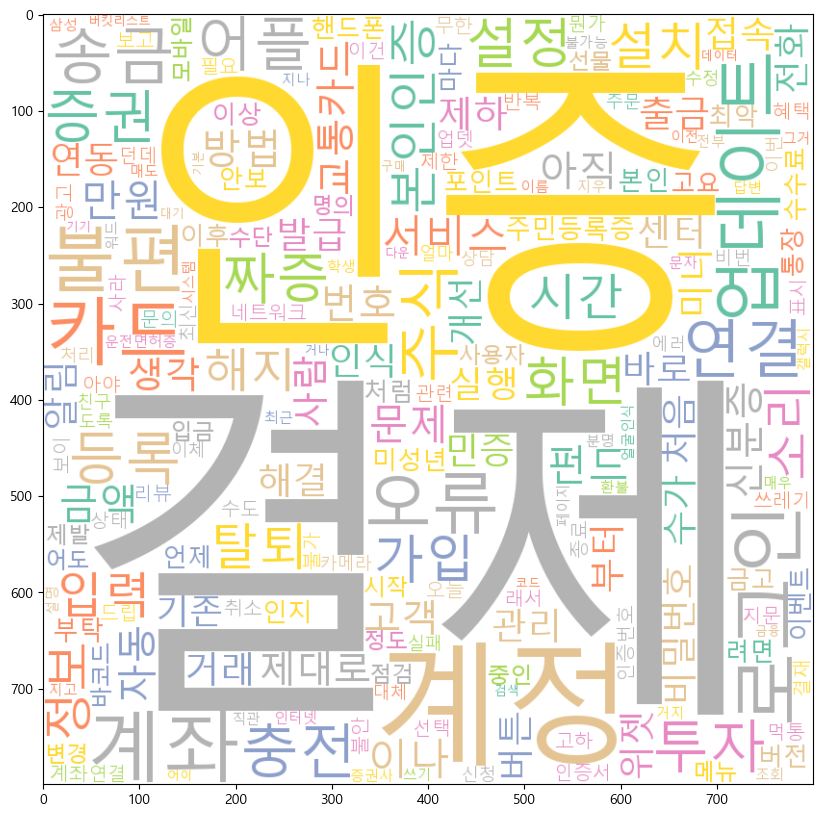

In [52]:
#### 2019년~~2023년

wordcloud=wordcloud.generate_from_frequencies(Counter(cleaned_nouns))
array=wordcloud.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

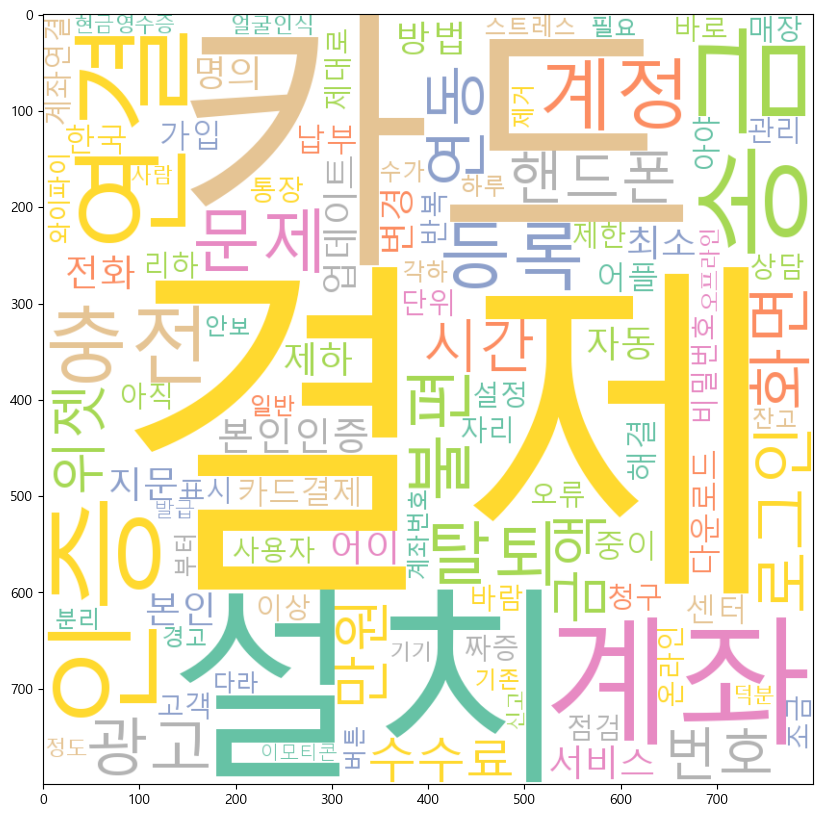

In [53]:
#### 2019년

df_words2019=Counter(y_19)
wordcloud_19=wordcloud.generate_from_frequencies(dict(df_words2019.most_common(100)))
array=wordcloud_19.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

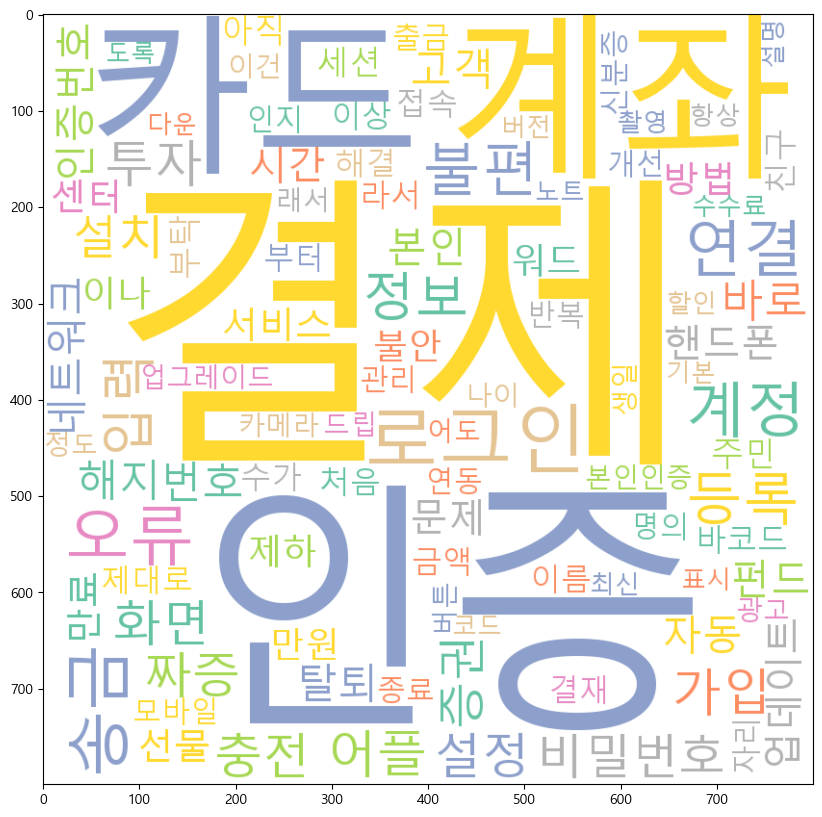

In [54]:
#### 2020년
df_words2020=Counter(y_20)
wordcloud_20=wordcloud.generate_from_frequencies(dict(df_words2020.most_common(100)))
array=wordcloud_20.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

In [55]:
Counter(y_21)

Counter({'결제': 98,
         '계정': 78,
         '소리': 64,
         '로그인': 60,
         '업데이트': 59,
         '계좌': 57,
         '불편': 52,
         '인증': 51,
         '투자': 51,
         '어플': 48,
         '연결': 48,
         '카드': 46,
         '탈퇴': 38,
         '충전': 35,
         '등록': 34,
         '오류': 33,
         '교통카드': 32,
         '가입': 32,
         '설정': 31,
         '설치': 30,
         '짜증': 27,
         '미니': 26,
         '송금': 26,
         '금고': 25,
         '화면': 24,
         '알림': 24,
         '관리': 23,
         '서비스': 22,
         '시간': 22,
         '연동': 22,
         '인증서': 22,
         '실행': 22,
         '기존': 21,
         '증권': 21,
         '사람': 21,
         '출금': 20,
         '방법': 20,
         '만원': 20,
         '전화': 19,
         '제하': 19,
         '입력': 19,
         '포인트': 19,
         '문제': 18,
         '정보': 18,
         '수가': 18,
         '통장': 18,
         '해결': 18,
         '해지': 18,
         '이나': 17,
         '시작': 17,
         '자동': 17,
         '제대로': 17,
   

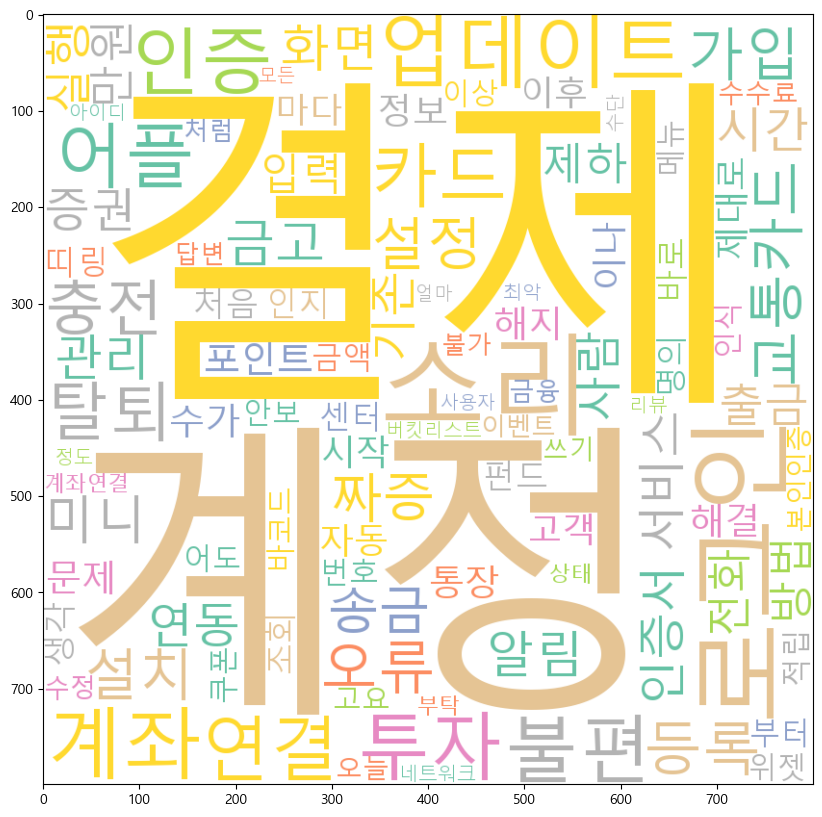

In [56]:
#### 2021년

df_words2021=Counter(y_21)
wordcloud_21=wordcloud.generate_from_frequencies(dict(df_words2021.most_common(100)))
array=wordcloud_21.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

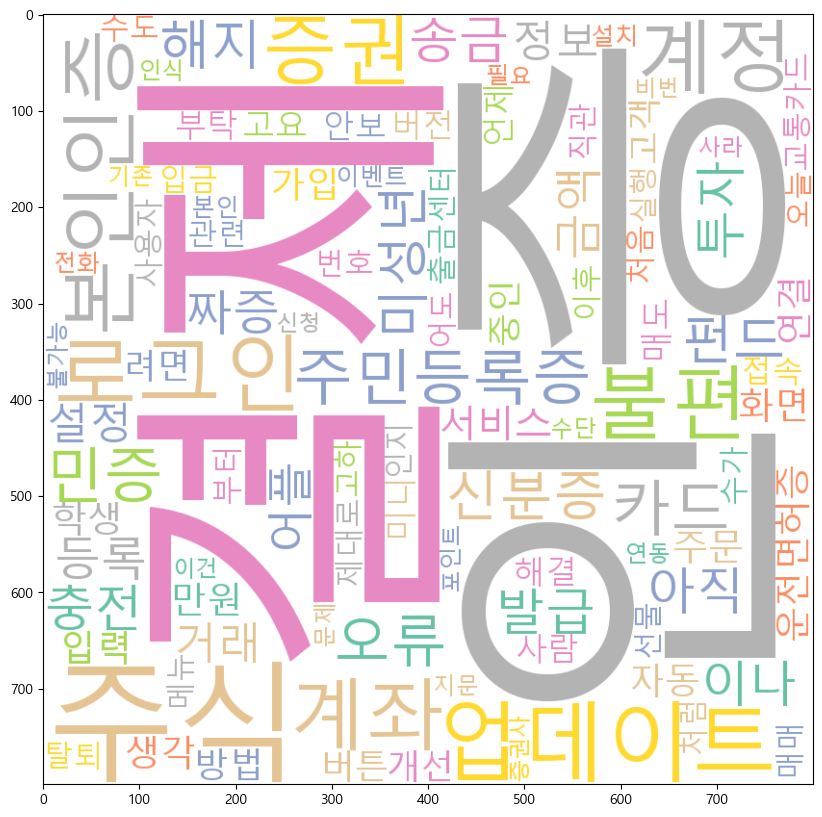

In [57]:
#### 2022년

df_words2022=Counter(y_22)
wordcloud_22=wordcloud.generate_from_frequencies(dict(df_words2022.most_common(100)))
array=wordcloud_22.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

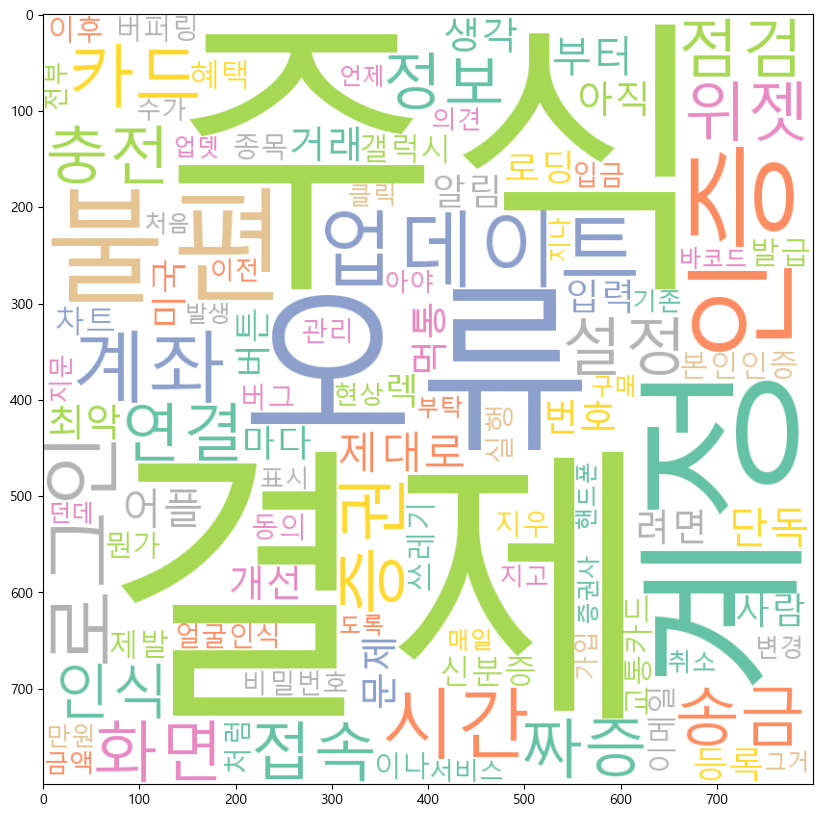

In [58]:
#### 2023년

df_words2023=Counter(y_23)
wordcloud_23=wordcloud.generate_from_frequencies(dict(df_words2023.most_common(100)))
array=wordcloud_23.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

In [59]:
data

,날짜,리뷰,별점,month,리뷰1,리뷰2
0,2023년 10월 18일,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...,1,2023년,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...,"[업뎃, 이후, 위젯, 먹통, 지우, 위젯, 등록, 잠깐, 시간, 지나, 위젯, 먹..."
1,2023년 10월 17일,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...,1,2023년,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...,"[송금, 화면, 숫자, 지우, 현상, 시적, 현상]"
3,2023년 7월 3일,"렉,버퍼링 겁나 느리고 화면 안뜸현상 짜증나요ㅠㅠ 주식은 타이밍이 전부인데... 특...",1,2023년,렉 버퍼링 겁나 느리고 화면 안뜸현상 짜증나요 주식은 타이밍이 전부인데 특히 미국주...,"[렉, 버퍼링, 화면, 현상, 짜증, 주식, 타이밍, 전부, 미국, 주식창, 메뉴얼..."
4,2023년 6월 9일,"자주 쓰는 서비스는 앞으로 꺼내고 --> 나에게 맞게 설정해 놓고 잘 쓰고 있는데,...",1,2023년,자주 쓰는 서비스는 앞으로 꺼내고 나에게 맞게 설정해 놓고 잘 쓰고 있는데 불편한 ...,"[자주, 서비스, 설정, 불편, 화면, 설정, 카드, 결제, 도록, 결제, 카드, ..."
5,2023년 6월 6일,"페이증권 처음사용인데,보조지표 기능도 부족하고.다른 증권사들처럼 가격이동평균 숫자....",2,2023년,페이증권 처음사용인데 보조지표 기능도 부족하고 다른 증권사들처럼 가격이동평균 숫자 ...,"[증권, 처음, 보조, 지표, 부족, 증권사, 처럼, 가격, 이동, 평균, 숫자, ..."
...,...,...,...,...,...,...
2988,2020년 5월 15일,결제계속오류나는데요,1,2020년,결제계속오류나는데요,"[결제, 오류]"
2992,2022년 5월 3일,계속오류떠요.......,1,2022년,계속오류떠요,[오류]
2995,2019년 6월 24일,본인확인 과정에서 자꾸 본인확인이아니라고해답답하세요,2,2019년,본인확인 과정에서 자꾸 본인확인이아니라고해답답하세요,"[본인, 과정, 본인, 고해]"
2996,2021년 5월 28일,리뷰 왜 삭제하십니까? 남혐논란 문의하고 그 담당 직원 징계 문의하면 답변을 줘야지...,1,2021년,리뷰 왜 삭제하십니까 남혐논란 문의하고 그 담당 직원 징계 문의하면 답변을 줘야지 ...,"[리뷰, 남혐, 논란, 문의, 담당, 직원, 징계, 문의, 답변, 리뷰, 그게, 해결]"


In [60]:
data=data.reset_index()
data

,index,날짜,리뷰,별점,month,리뷰1,리뷰2
0,0,2023년 10월 18일,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...,1,2023년,업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지...,"[업뎃, 이후, 위젯, 먹통, 지우, 위젯, 등록, 잠깐, 시간, 지나, 위젯, 먹..."
1,1,2023년 10월 17일,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...,1,2023년,송금하기 누르면 화면이 떨려서 숫자를 못 누르겠어요 지우고 다시 깔았는데도 똑 같은...,"[송금, 화면, 숫자, 지우, 현상, 시적, 현상]"
2,3,2023년 7월 3일,"렉,버퍼링 겁나 느리고 화면 안뜸현상 짜증나요ㅠㅠ 주식은 타이밍이 전부인데... 특...",1,2023년,렉 버퍼링 겁나 느리고 화면 안뜸현상 짜증나요 주식은 타이밍이 전부인데 특히 미국주...,"[렉, 버퍼링, 화면, 현상, 짜증, 주식, 타이밍, 전부, 미국, 주식창, 메뉴얼..."
3,4,2023년 6월 9일,"자주 쓰는 서비스는 앞으로 꺼내고 --> 나에게 맞게 설정해 놓고 잘 쓰고 있는데,...",1,2023년,자주 쓰는 서비스는 앞으로 꺼내고 나에게 맞게 설정해 놓고 잘 쓰고 있는데 불편한 ...,"[자주, 서비스, 설정, 불편, 화면, 설정, 카드, 결제, 도록, 결제, 카드, ..."
4,5,2023년 6월 6일,"페이증권 처음사용인데,보조지표 기능도 부족하고.다른 증권사들처럼 가격이동평균 숫자....",2,2023년,페이증권 처음사용인데 보조지표 기능도 부족하고 다른 증권사들처럼 가격이동평균 숫자 ...,"[증권, 처음, 보조, 지표, 부족, 증권사, 처럼, 가격, 이동, 평균, 숫자, ..."
...,...,...,...,...,...,...,...
1794,2988,2020년 5월 15일,결제계속오류나는데요,1,2020년,결제계속오류나는데요,"[결제, 오류]"
1795,2992,2022년 5월 3일,계속오류떠요.......,1,2022년,계속오류떠요,[오류]
1796,2995,2019년 6월 24일,본인확인 과정에서 자꾸 본인확인이아니라고해답답하세요,2,2019년,본인확인 과정에서 자꾸 본인확인이아니라고해답답하세요,"[본인, 과정, 본인, 고해]"
1797,2996,2021년 5월 28일,리뷰 왜 삭제하십니까? 남혐논란 문의하고 그 담당 직원 징계 문의하면 답변을 줘야지...,1,2021년,리뷰 왜 삭제하십니까 남혐논란 문의하고 그 담당 직원 징계 문의하면 답변을 줘야지 ...,"[리뷰, 남혐, 논란, 문의, 담당, 직원, 징계, 문의, 답변, 리뷰, 그게, 해결]"


In [61]:
data['리뷰2'][999]

['신분증', '인식', '처음', '직접', '게라']

In [62]:
list(range(len(data)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [63]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '주식' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i])       

렉 버퍼링 겁나 느리고 화면 안뜸현상 짜증나요 주식은 타이밍이 전부인데 특히 미국주식창은 요번에 메뉴얼 화면보기 방식이 바뀌어서 더 그런건지 핸드폰 갤 플러스 집에 기가와이파이 소프트업그레이드 전부 완료되어있는데도 화면 개 느려터져서 나오질않아요 모바일네트워크도 마찬가지 저번에도 이런일이 좀 심각하게 터져서 공식사과하고 피해보상 접수받고 했던걸로 기억하는데 이런 현상이 너무 빈번하니까 개인 네트워크 문제다 라고만 치부할수 없는거 아닌가 싶네요 속터져서 다른쪽으로 옮겨야하나 싶고 진짜 삭제후 새로 깔고 인증하고 다해도 똑같고 이럴때마다 왜 이걸 깔고 거래해서 스스로 스트레스 받고있나 싶을때가 많네요 접속자수 많이 몰리는 앱은 수시로 점검해야 하는게 마치않나요
근래 업데이트때마다 진심으로 묻고 싶네요 주식거래는 하고 있는 사람들이 만들고 최종 컨펌하는거 맞나요 왜 몇번씩 클릭하도록 다 따로따로 떼어놓은거죠 다른건 몰라도 정보탭과 보유탭 내용은 묶여있어야죠 주식거래하는 사람이 종목정보나 보자고 종목 클릭해서 들어가는거 아니잖아요 보유주식 각각의 현황확인과 매수매도를 위해 클릭하는건데 종목클릭하면 정보탭이 디폴트라 헌황 확인하려면 보유탭 한번더 클릭하게 되잖아요 개 탭으로 나눠놓은거 정말 불편하고 무의미하다고 생각합니다 자꾸 뭔가 더할려고 안했으면 좋겠어요 다른 회사 흉내내려고 하지말고 카카오 색을 지켰으면 좋겠네요 바꾸려면 정말 잘 만들어서 내놓던가요 미완성 버전 급하게 올려놓은것 같잖아요
주식차트에 일봉차트 렉좀 없애주세요 걸리는게 있고 안걸리는게 있음 기준은 모름 몇개월째 그렇습니다 주봉 월봉은 렉안걸림니다
많이 좋아졌는데 디자인은 그만 바꾸고 미국주식하려면 미국주식하는 사람들은 알겠지만 일이평선 추가가 중요합니다 일 이평선 추가해주면 더 좋을것 같습니다
왠만하면 귀찮아서 리뷰안남기고 안쓰고 말지하는 사람인데 이걸 안쓸수도없고 어쩔수없이 리뷰 남김 업데이트되고나서부터 렉 버퍼링 너무 심한거아닌갸 하루 이틀이라도 열받을 마당에 이게 지금 계속 지속되고있는건 확실하

In [64]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '렉' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i])       

렉 버퍼링 겁나 느리고 화면 안뜸현상 짜증나요 주식은 타이밍이 전부인데 특히 미국주식창은 요번에 메뉴얼 화면보기 방식이 바뀌어서 더 그런건지 핸드폰 갤 플러스 집에 기가와이파이 소프트업그레이드 전부 완료되어있는데도 화면 개 느려터져서 나오질않아요 모바일네트워크도 마찬가지 저번에도 이런일이 좀 심각하게 터져서 공식사과하고 피해보상 접수받고 했던걸로 기억하는데 이런 현상이 너무 빈번하니까 개인 네트워크 문제다 라고만 치부할수 없는거 아닌가 싶네요 속터져서 다른쪽으로 옮겨야하나 싶고 진짜 삭제후 새로 깔고 인증하고 다해도 똑같고 이럴때마다 왜 이걸 깔고 거래해서 스스로 스트레스 받고있나 싶을때가 많네요 접속자수 많이 몰리는 앱은 수시로 점검해야 하는게 마치않나요
주식차트에 일봉차트 렉좀 없애주세요 걸리는게 있고 안걸리는게 있음 기준은 모름 몇개월째 그렇습니다 주봉 월봉은 렉안걸림니다
왠만하면 귀찮아서 리뷰안남기고 안쓰고 말지하는 사람인데 이걸 안쓸수도없고 어쩔수없이 리뷰 남김 업데이트되고나서부터 렉 버퍼링 너무 심한거아닌갸 하루 이틀이라도 열받을 마당에 이게 지금 계속 지속되고있는건 확실하게 문제있음 개선해야됨 결제할때마다 카카오페이쓰는데 로딩하는데 기본 버퍼링 초이상 잡아먹고 등록해둔 카드로 결제하려고 옆으로 슬라이드하면 포인트창으로 넘어가는게 한두번이 아님 주식도 마찬가지 겁나 불필요하게 번잡하게 돼있어서 실시간으로 확인하기 불편함 혜택에서 포인트모으기도 이용하는데 진짜 렉 버퍼링 제발 일좀 제대로 합시다
렉걸려서 지워야 겠다 손실금이 이만저만 아니다 토스나 키움 나무 써야하나
운영진님께 아니아디찾아서접속해도안되그럼어캐앱을사용하나요 답답하네요진짜 시간째 시름중인데 짜증나네요 렉인가요오류인가요
카드를 잃어버려서 출금기능을 이용하는데 일부터 갑자기 ATM출금인증번호 창이 나오질 않네요 어플렉인줄알았는데 아직까지도 안되고있네요
업데이트하고 계속 렉걸려서 들어가지가 않아요
지난 몆년간 썻는데 그냥 렉도심하고 충전하고 송금하려는데 송금은안되고충전만계속되는 쓰레기어플
너무

In [65]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '충전' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

결제할 때 카드를 선택해놓고 시간이 지나서 폰 화면이 꺼졌을 때 다시 화면을 켜면 카드가 아니라 카카오페이머니로 바뀌어버리네요 바뀐 줄 모르고 그대로 결제를 해버릴 경우엔 현금 충전까지 돼버리는데 너무 짜증납니다 카드로 결제하려다가 괜히 쓸데없는 불편을 겪게 돼서 앞으로 이 앱에서 결제는 안 써야겠습니다
진짜 모바일 티머니 충전할려는데 왜자꾸 몇번을 인증을 하라는거죠 최악입니다
며칠 전부터 주식 알림이 오기에 설정에 들어가보니 서비스 이용 알림을 뭐이리 뭉쳐놨는지 각 항목마다 구분시키기 바랍니다 송금 충전 결제 투자 등
증권은 베타라 아직 이런가요 기능도 갖추지 않은 듯하고 많이 부족해 보이네요 소액만 사용해보고 넘어가려 했는데 아직 넘어가면 안될 것 같네요 통장에서 자동 충전 되는것 외엔 너무 불편하네요 기대했는데 생각보다 별로입니다 그리고 증권플러스 연동 빨리 되면 좋겠네요 그래야 그나마 쓸 듯
업데이트 되고 메뉴가 늘어나는데 도대체 충전버튼은 어디있나요 기본기능이 좀 쉬웠음좋겠는데 충전버튼 찾다가 스트레스받아서 카톡들어가서 함 짜증나서 앱 지움
현재는 잘 쓰고있긴한데 고객센터연결 시도하고까먹고시도하고까먹고 몇번이나좌절되다보니 잊고지냈었네요 이유인즉슨 년 폰을바꾸기전 페이 만원을 충전하였지만 바뀐폰에서 만원이 확인안되고 사라져서 새로충전 후 그냥썼었고 종종 실물확인위한 고객센터연결을 시도하였지만 난해한ARS만 나오기에 어쩌다 보니 많은시간이흘렀네요 혹 이문제 추적하여 해결이 가능할까요 이 앱에 첨으로 리뷰남겨봅니다
와이파이가 멀쩡하게 잘 연결돼 있는데도 연결 상태가 안 좋다면서 충전을 할 수가 없게 해요 데이터를 켜도 마찬가지고요
업데이트되고 당황 결제하는 페이지 오른쪽상단에 잔액보여주고 충전하게 되있는걸 알람으로 바꿔서 너무너무 불편 결제하려면 내 페이잔액을알아야할껀데 잔액모자르면 버튼누르고 바로충전하고 직관적으로 보였는데 왜 없앴는지 이해불가 너무너무불편 충전어디있는지한참찾음
미성년자는 전에 등록해둔 통장으로 PAY머니 충전은 되는데 출금은 안되네요 본

In [66]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '포인트' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

왠만하면 귀찮아서 리뷰안남기고 안쓰고 말지하는 사람인데 이걸 안쓸수도없고 어쩔수없이 리뷰 남김 업데이트되고나서부터 렉 버퍼링 너무 심한거아닌갸 하루 이틀이라도 열받을 마당에 이게 지금 계속 지속되고있는건 확실하게 문제있음 개선해야됨 결제할때마다 카카오페이쓰는데 로딩하는데 기본 버퍼링 초이상 잡아먹고 등록해둔 카드로 결제하려고 옆으로 슬라이드하면 포인트창으로 넘어가는게 한두번이 아님 주식도 마찬가지 겁나 불필요하게 번잡하게 돼있어서 실시간으로 확인하기 불편함 혜택에서 포인트모으기도 이용하는데 진짜 렉 버퍼링 제발 일좀 제대로 합시다
요즘 왜이리 느려터지고 끊기고 그러나요 접속하기가 너무힘듬 접속이 되도 포인트모으기 누르면 세월아네월아 로딩만함
레전드 교통카드지갑이랑 일반페이지갑이랑 따로네요 교통카드 충전기능은 잘 숨겨둬서 앱 다 헤집고 다녔습니다 리뷰를 수정까지 하게 하다니 기능이 겁나게 많으면 기능검색이라도 되게 해주세요 페이앱에서 큐알코드 스캔결제는 안되나요 결제과정이 너무 불편합니다 화면만 단순하지 절차가 간단한건 아니네요 네이버페이보다 포인트 많이줘서 골랐다가 매번 짜증나서 그냥 취소하고 네이버페이로 결제하는것같네요 광고넣을공간에 자주쓰는 기능을 넣어주세요
쓰레기 던킨 천원 할인한다고 처음으로 결제했더니 할인도 안되고 그냥 전액 결제됨 취소해달랬더니 취소도 오류나고 안됨 그냥 해피포인트로 결제했으면 할인이나 받지 괜히 쓰레기페이 썻다가 피해만봄 그냥 오로지 결제만 잘됨 다시는 쓸일 없을듯
걷기왕 춘식이 만보기를 쓰면서 페이포인트도 받을 수 있게 개선 업데이트하면 좋을거 같아요
알리워드를 할인쿠폰으로 주는건 또 뭔가요 최근에 리워드 금액이 처음보다 확 줄었다고 느끼긴 했는데 이제는 쓰지도 않는 쿠폰을 주면서 떼워버리네요 이제 카카오페이로 결제하는 일은 두번다시 없을겁니다 답변확인후 추가 말을 참 그럴듯하게 써놓으셨네요 쿠폰 추가지급이요 다시 확인해봐도 알 리워드는 쿠폰밖에 없는데요 캐시백이나 포인트는 들어온게 없습니다 추가지급이 아니라 지급수단이 추가 된 

In [67]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '주민등록증' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

인증방법을 꼭 주민등록증으로 해야하는 건가요 제가 주민등록증을 잃어버려서 언제 발급받았는지 기억이 안나는데 이것 때문에 저번에 개인적인 일로도 좋지 못한 상황이 생겼는데 이번에도 또 좋지 못한 상황이 생겼어요 꼭 주민등록증으로 인증해야하지 않는 이상 다른 인증방법도 만들어놨으면 좋겠네요
어느날 갑자기 인증을 하래서 하려는데 학생신분으로도 예전에는 잘 됐었는데 학생신분인데도 인증을 운전면허증과 주민등록증으로만 인증이 가능함 인증이 불가능해져서 여러 기능을 사용하지 못하고 있음
단말기 변경 후 본인인증에서 미성년자는 어떻게 로그인하라는 건지 모르겠네요 주민등록증도 운전면허증도 없는데 뭐 어쩌라는건지
아니 진짜 답답해서 미치겠어요 안전한 인증인가 그걸 하라는데 주민등록증으로 인증을 하래요 주민등록증이 없는데 송금도 못하고 만들어 논 카드도 못 쓰고 돈이 잠겨 있고 아니 주민등록증이나 운전면허증이 있어야 번호를 입력하든지 말든지 하죠 오륜가 싶어서 몇번이나 시도 하고 삭제도 했는데 카카오페이에서 그리고 카카오톡 앱에서도 이러면 어쩌자는거에요
본인인증할때 주민등록증을 사용해야하는데 시간이 없어 미발급 받은 상황이라 이 상황에 발급을 받아야 사용이 가능하다니 참 안타깝네요 바쁜 시기에 고생이 좀 있겠지만 다른 방법이 없을지 조심히 여쭤봅니다
아니 무슨 주민등록증 인증을 하는데 찍어도 계속 안되고 어두운 배경에 놓아도 안된다하고 빛반사된다해서 계속 옮겨서 해도 안된다하고 뭐하는 건지 최소한 주민등록증 날짜 수기입력을 하게라도 하던가 뭐하는 겁니까 아침부터 사람 열뻗치게
본인인증을 해달라는데 주민등록증이나 운전면허증이 없으면 본인인증이 안되네요 아직 주민등록증 발급 받지도 않았고 애초에 주민등록증 발급받기 전에 앱을 다운 받아서 쓰던거라 당장 발급받는다고 해도 등록은 되있지 않을것 같은데요
갑자기 주민등록증이나 운전면허증으로 인증해야지 쓸 수 있다고 뜨는데 미성년자는 쓰지 말라는 건가요 원래는 잘 쓰고 있었는데
아직 주민등록증 신청 안해서 현재 없는 상태인데 본인 확인을 성

In [68]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '상태' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i])

최근들어 수차례에 걸쳐 결제하려고 앱을 열면 카카오페이 연결이 지연된다는 메시지가 뜨고 카카오페이바로가기를 클릭하면 계속 깜박거리는 현상이 나타났습니다 이런 결과로 결제는 할 수도 없고 앱을 삭제하고 다시 깔기를 반복을 하는데 반복적인 이런 상태에 좀 매우 불편함을 느끼고 있습니다 확인부탁드립니다
다른건 몰라도 알굴인식만큼은 처참하다 왜 해뒀나 싶다 가끔 한번에 성공한다 마스크 꼈든 생얼이든 상관없이 한번에 그리고 나머지도 마르크 끼든 아니든 상관없이 수차례 시도해도 인식못한다 그럼 왜 만든거지 마스크낀 상태이든 화장을 했든 생얼이든 상관없이 대부분 인식 봇하다가 가끔 인식되는게 재대로 만들어진것인가 싶다 차라리 기본 탑제되어있는 지문인식이 잘된다 지문인식이 번중에서 번만 인식못하고 잘되는 반면 카카오페이는 번중에서 번만 인식할 수준의 처참한 차이인데 말이다
ARS 인증 전화가 아예 안오는데요 무슨 등록 과정에 오류 뜨는것고 아니고 전화 자체가 아예 안 온상태에서 넘어가놓고 계좌 등록하려하면 ARS 오류 떴다 하는데 전화가 안 오는데 어떻게 인증 하나요 후후 안 하구요 한국유심이구요 스팸번호 설정 안 해놨습니다 설마 국외에 있으면 계좌등록을 아예 못하나요
와이파이가 멀쩡하게 잘 연결돼 있는데도 연결 상태가 안 좋다면서 충전을 할 수가 없게 해요 데이터를 켜도 마찬가지고요
최악의 기업답게 APP도 최악 이네요 무한 루프에 빠져서 먹통상태로 노답입니다
카카오페이교통카드 너무 짜증나네요 기존사용하던 교통카드어플 수수료 원 감내하며 환불하고 카카오교통으로 갈아탔는데 삼성페이 사용하면 안된다니 아래 리뷰를 진작봤으면 좋았을텐데 이미 카카오페이에 충전도 해놓은 상태인데 제대로 내용공지도 안하시고 홍보만 수수료 없는 충전 이렇게하시면 어떻게 하나요 충전금액 환불하려고 하니 수수료 하 원 장난하는건가요 이렇게 돈버실려고 만든건가요 당일충전한지 분정도 됐는데 수수료떼이고 기존앱에서도 수수료떼이고 이중손해인데 이렇게 손해보는 이용자들 어찌하실건지 왜 부족한 정보로 이용자가 피해

In [69]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '등록' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

업뎃이후 잘쓰던 위젯이 먹통이 됐다 지우고 위젯 등록을 다시해도 잠깐 되다 시간 지나서 눌러보면 위젯이 먹통이다 네이버 페이 위젯은 잘된다 각성해라 카카오 추가 여전히 문제가 그대로다 다른 문제도 발견했다 다크모드 사용시 위젯의 바코드가 보이지를 않아 사용이 불가능하다 카카오 각성해라 사용자의 입장에서 앱을 만들어라 좀 그게 안되나
왠만하면 귀찮아서 리뷰안남기고 안쓰고 말지하는 사람인데 이걸 안쓸수도없고 어쩔수없이 리뷰 남김 업데이트되고나서부터 렉 버퍼링 너무 심한거아닌갸 하루 이틀이라도 열받을 마당에 이게 지금 계속 지속되고있는건 확실하게 문제있음 개선해야됨 결제할때마다 카카오페이쓰는데 로딩하는데 기본 버퍼링 초이상 잡아먹고 등록해둔 카드로 결제하려고 옆으로 슬라이드하면 포인트창으로 넘어가는게 한두번이 아님 주식도 마찬가지 겁나 불필요하게 번잡하게 돼있어서 실시간으로 확인하기 불편함 혜택에서 포인트모으기도 이용하는데 진짜 렉 버퍼링 제발 일좀 제대로 합시다
국내에서 사용 가능한 모든 금융 관련 어플중에서 비밀번호 등록이 가장 어려운 어플 보통 사용자들은 자기가 쓰기 편하고 손에 익은 비번을 사용하려 하는데 얘네는 일단 무조건 사용 불가능한 비번이라고 못 박고 시작함 사용자가 원하는 비번이 아닌 카카오 본인들이 원하는 비번을 요구하는 어플임 그거 빼고는 사용이 편하긴함
지문 새로 등록 하지도 않았는데 등록하라고 뜨고 불안에서 사용하지 못하겠음
토 쓰다가 보안땜에 넘어왔는데 너무 불편하네요 제가 기능을 모르는 건지 직관성이 없어요 자산관리 카테고리내에서 바로 송금이 안되고 송금 카테고리에서만 송금 가능한 점 송금할 때 출금계좌의 잔액 바로확인이 불가하다는 점 보내봐야 부족한지 알 수 있음 송금하면 카카오페이를 거쳐가기때문에 항상 그 이상의 금액이 출금됨 정확한 계산어려움 계좌를 꾹 눌렀을때 계좌정보확인 및 별명설정 기능이 없는 점 설정창에서 계좌정보를 바꿀 수 있단걸 검색해서 알았음 최신 정보 업데이트 완료가 안되는 점 잔액확인 안돼서 이체못함 갱신중일땐 계좌 

In [70]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '로그인' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

아니 폰만 다르지 계정자가 같은데 한번 로그인하고 송금확인하면 또 인증또인증 뭐하는거죠 인증해서 접속을 했는데 왜 인증 되면 뭐라도 안켔는데 이미 가입되어 있습니다 고객센터 확인 어디가서 뭘 확인하고 카톡하고 바로 연계되고 접속되게 해야지 이건문 풀펴해서 쓰겠나 친구가 좋타도해서 쓸라했더만 선물받은 돈도 못찾고 뭐 개수작인지 별점도 아깝네
앱을 만들면 보통 개발자들이 사전 테스트를 하지 않나요 이 앱이 테스트에서 통과가 됐다면 개발자들과 컨펌한 관리자들 모두 잘못된거 아닌가요 계정 로그인을 하려고 할 때마다 오류는 반복이고 화면 멈춤도 반복이고 앱 휴대폰 소프트웨어 버전 모두 최신버전인데 고객센터 문의하니 해당부서 확인해야 한다고 며칠이 걸리고 증권계좌 개설을 하려고 할때도 신분증 촬영도 똑바로 안되고 문의를 해도 또 며칠걸리고 고객이 우선이 아닌 만든 개발자들 스케줄이 우선인 앱 같아요 충전지연 바코드 결제오류 무수히 많은 오류들이 반복되는데 시정되는건 없고 패턴이 늘상 같네요 IOS 버전에 따라 업그레이드 된다고 설명은 하고 있는것 같은데 오류도 같이 업그레이드 되는건가요 뭐 하나 시정되는것도 없고 늘 잠시뒤 시도 분 뒤 다시시도 해결책은 없고 유저가 불편을 겪고 기다려야 하나요 다신 안씁니다 서비스 늘리기 이전에 앱의 기본부터 되돌아보세요 기초공사가 부실공사인데 말만 거창한 것 같네요
이런 패이류 앱들이 간편하게 사용할수있어 좋긴한데 이전부터 불편 했던게 결제화면에 잔액표시 안뜨게 할순 없는가 입니다 결제전 사용자가 로그인하면 확인할수 있게 하고 매장결제 할땐 안보이게 해야 정상인것 같은데 말이죠 주거래은행 통장잔고는 아니지만 잔액이 많고적음을 떠나 일종의 프라이버시에 속하는 문제라 생각하는 인입니다 일반 카드로 긁을때는 판매자가 잔액 얼마남았는지 알수없잖아요
카카오페이 로그인 설정 변경되었나요 설정 비밀번호 비밀번호 변경 생체인증 사용 얼굴인식 사용 얼굴인식 사용으로 로그인 했는데 얼굴인식 사용이 안되고 생체인증 사용으로 사용함 지문인식 잦은오류 때문에

In [71]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '주식' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

렉 버퍼링 겁나 느리고 화면 안뜸현상 짜증나요 주식은 타이밍이 전부인데 특히 미국주식창은 요번에 메뉴얼 화면보기 방식이 바뀌어서 더 그런건지 핸드폰 갤 플러스 집에 기가와이파이 소프트업그레이드 전부 완료되어있는데도 화면 개 느려터져서 나오질않아요 모바일네트워크도 마찬가지 저번에도 이런일이 좀 심각하게 터져서 공식사과하고 피해보상 접수받고 했던걸로 기억하는데 이런 현상이 너무 빈번하니까 개인 네트워크 문제다 라고만 치부할수 없는거 아닌가 싶네요 속터져서 다른쪽으로 옮겨야하나 싶고 진짜 삭제후 새로 깔고 인증하고 다해도 똑같고 이럴때마다 왜 이걸 깔고 거래해서 스스로 스트레스 받고있나 싶을때가 많네요 접속자수 많이 몰리는 앱은 수시로 점검해야 하는게 마치않나요
근래 업데이트때마다 진심으로 묻고 싶네요 주식거래는 하고 있는 사람들이 만들고 최종 컨펌하는거 맞나요 왜 몇번씩 클릭하도록 다 따로따로 떼어놓은거죠 다른건 몰라도 정보탭과 보유탭 내용은 묶여있어야죠 주식거래하는 사람이 종목정보나 보자고 종목 클릭해서 들어가는거 아니잖아요 보유주식 각각의 현황확인과 매수매도를 위해 클릭하는건데 종목클릭하면 정보탭이 디폴트라 헌황 확인하려면 보유탭 한번더 클릭하게 되잖아요 개 탭으로 나눠놓은거 정말 불편하고 무의미하다고 생각합니다 자꾸 뭔가 더할려고 안했으면 좋겠어요 다른 회사 흉내내려고 하지말고 카카오 색을 지켰으면 좋겠네요 바꾸려면 정말 잘 만들어서 내놓던가요 미완성 버전 급하게 올려놓은것 같잖아요
주식차트에 일봉차트 렉좀 없애주세요 걸리는게 있고 안걸리는게 있음 기준은 모름 몇개월째 그렇습니다 주봉 월봉은 렉안걸림니다
많이 좋아졌는데 디자인은 그만 바꾸고 미국주식하려면 미국주식하는 사람들은 알겠지만 일이평선 추가가 중요합니다 일 이평선 추가해주면 더 좋을것 같습니다
왠만하면 귀찮아서 리뷰안남기고 안쓰고 말지하는 사람인데 이걸 안쓸수도없고 어쩔수없이 리뷰 남김 업데이트되고나서부터 렉 버퍼링 너무 심한거아닌갸 하루 이틀이라도 열받을 마당에 이게 지금 계속 지속되고있는건 확실하

In [72]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '휴대폰' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

앱을 만들면 보통 개발자들이 사전 테스트를 하지 않나요 이 앱이 테스트에서 통과가 됐다면 개발자들과 컨펌한 관리자들 모두 잘못된거 아닌가요 계정 로그인을 하려고 할 때마다 오류는 반복이고 화면 멈춤도 반복이고 앱 휴대폰 소프트웨어 버전 모두 최신버전인데 고객센터 문의하니 해당부서 확인해야 한다고 며칠이 걸리고 증권계좌 개설을 하려고 할때도 신분증 촬영도 똑바로 안되고 문의를 해도 또 며칠걸리고 고객이 우선이 아닌 만든 개발자들 스케줄이 우선인 앱 같아요 충전지연 바코드 결제오류 무수히 많은 오류들이 반복되는데 시정되는건 없고 패턴이 늘상 같네요 IOS 버전에 따라 업그레이드 된다고 설명은 하고 있는것 같은데 오류도 같이 업그레이드 되는건가요 뭐 하나 시정되는것도 없고 늘 잠시뒤 시도 분 뒤 다시시도 해결책은 없고 유저가 불편을 겪고 기다려야 하나요 다신 안씁니다 서비스 늘리기 이전에 앱의 기본부터 되돌아보세요 기초공사가 부실공사인데 말만 거창한 것 같네요
월 일 미니금고 투자 먹통인 분들 고객센터 답변 공유함 카카오페이어플을 통해 확인 시 미노출 사유는 최근 ANDROID SYSTEM WEBVIEW가 버전 최신버전 으로 업데이트되면서 웹뷰의 오류로 기존 카카오페이앱과 충돌하여 진입이 실패 되고 있는 것으로 확인됩니다 카카오페이어플을 통해 투자 서비스등 원활하게 이용하고자 하시는 경우 번거로우시겠지만 아래 방법으로 ANDROID SYSTEM WEBVIEW 업데이트 삭제 후 이용시도 부탁드립니다 휴대폰 설정 어플리케이션 WEBVIEW 검색 ANDROID SYSTEM WEBVIEW 선택 오른쪽 상단 점 세개 업데이트 삭제 위 방법 안되는 분은 설정 어플리케이션 CHROME 검색 CHROME 선택 오른쪽 상단 점 세개 업데이트 삭제 이후 하단의 사용 중지 클릭
인증이 안되요 휴대폰이 신랑 명의로 되어있어 최초 카카오톡도 신랑정보로 되어있으면 이용할수 없나요 인증정보가 다르다고 계속 오류입니다 삭제하고 다시 깔아도 카톡을 새로 시작해야하나 우쒸
로그인하려면 휴대폰 인증

In [73]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '알림' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

주식할때 버퍼링때문에 손해 엄청봣구요 제발 빨리팔수있게 간편판매 알림 안뜨게 할수있게 해주세요
카카오톡으로 오는 카카오페이 공모주 알림톡의 정보가 정확했던 예전과 달리 간간히 부정확합니다 공모주 청약이나 상장일 알림이 떠서 세부사항 일정에 들어가봐도 해당사항이 없는 경우가 있습니다 청약이 시작되어도 공모예정가 최저가 최고가 가 떠 있거나 경쟁률이 시 마감 때까지 대기중으로 계속 떠 있거나 하는 중대한 오류를 한 두번 본 게 아닙니다 처음에는 실수겠지 했는데 너무 잦아져서 여기에 컴플레인까지 올립니다 이게 시스템 오류가 나서 먹통이 된다던가 하는 것도 아니고 정보값 넣는 부서에서 계속 실수를 하고 있다는 건데 이런 케이스를 어디에서 본 적도 없어서 황당하네요 정상화 부탁합니다
내게 필요하지 않은 광고가 지나치게 많이 옵니다 알림을 어디서 제거해야하는지 못찾겠습니다 카카오페이를 사용하려고 하면 이 불필요한 투자광고들을 시도때도 없이 톡으로 받아야 하는 건지요 광고가오지 않는 다른 페이로 갈아타고 싶습니다 편리하게사용하려고 페이를 사용하는 건데 왜 이런 쓸데 없는 광고 때문에 스트레스를 받아야하는 건지요
카카오페이증권 실시간 상승 주식 알림 끄려고 메뉴도 열심히 뒤져보고 검색도 해 봤는데 결국 못 찾아서 지우기로 함 내 탓은 아닌 듯 함
며칠 전부터 주식 알림이 오기에 설정에 들어가보니 서비스 이용 알림을 뭐이리 뭉쳐놨는지 각 항목마다 구분시키기 바랍니다 송금 충전 결제 투자 등
앱에 숫자 이 없어지질않음 NEW라고 되어있거나 뭔가 빨간색이 찍힌 모든 메뉴를 다 들어가봐도 없어지질않음 쿠폰은 강제로 중국알리페이에 내 정보를 넘기라면서 삭제도 안됨 심지어 알림들 다 안받는걸로 설정했는데도 광고문구가 알림으로 뜸 이런 쓰레기앱을 믿고 지불수단으로 쓸 수가 있을까 싶음
앱 켤 때 띵 소리 알림 나는 거 너무 싫어요 업데이트 하면서 바꼈는데 알림 소리 싫어하는 사람도 있는데 갑자기 바꾸고 변경 설정도 안 되게 해 놓은거 진짜 무례하다고 생각해요
이야 펀드 알림은 또 왜 따

In [74]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '번호' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

생각할수록 이해가 불가능합니다 한달 실적을 채워서 쓰면서 현금 편의점 ATM 출금 할때 카드 무료 가능하지만 인증번호 출금 신청 할때 수수료 받는 의미하는 이유가 무엇인지 카드 인증 번호 둘다 무료로 하든가 하나는 무료 하나는 유료 그럴때마다 실적을 달성 할이유가 없다고 판단합니다
진짜 개 얼탱이 없음 비번 다시 설정해서 로그인할려는데 권한에 의해 취소 되었다면서 분후에 로그인 하라고 난리임 와중에 분 훨씬 지났는데도 인증 못 하게 하는건 뭐임 새로 설정한 번호도 틀렸다고 하면 도대체 뭘 입력하란거임 인증만 번했는데 다음페이지로 넘어가지도 않고 웬만해서는 속으로 욕하고 리뷰 안 남기겠지만 진짜 서비스 이용하는 입장에서는 답답하고 엄청 짜증남
ARS 인증 전화가 아예 안오는데요 무슨 등록 과정에 오류 뜨는것고 아니고 전화 자체가 아예 안 온상태에서 넘어가놓고 계좌 등록하려하면 ARS 오류 떴다 하는데 전화가 안 오는데 어떻게 인증 하나요 후후 안 하구요 한국유심이구요 스팸번호 설정 안 해놨습니다 설마 국외에 있으면 계좌등록을 아예 못하나요
그냥 다른 인터넷 뱅킹 좋은 거 많으니까 그 쪽 쓰는 게 맘편합니다 기기변경 번호변경 하신 분들 있으면 인증도 안되구요 심지어 바꾸는 절차도 사람 짜증날 정도로 합니다 덕분에 만원 묶여있어서 아무것도 못하는 중
아니 무슨 핸드폰 번호 바꾸면 인증이 안됩니까 방법이 탈퇴밖에 없으면 사놓은 이모티콘이랑 대화는요 업무상 중요한 내용도 많은데 그거 카카오페이 하나 때문에 다 지우라는건가요 진짜 어이없네요
번호가 바뀌면서 계정이 추가되고 페이가 연결이 안됩니다 돈은 자동으로 전계정으로 통장서 충전이 되고 빠져나갔는데 어째야되는지
아니 진짜 답답해서 미치겠어요 안전한 인증인가 그걸 하라는데 주민등록증으로 인증을 하래요 주민등록증이 없는데 송금도 못하고 만들어 논 카드도 못 쓰고 돈이 잠겨 있고 아니 주민등록증이나 운전면허증이 있어야 번호를 입력하든지 말든지 하죠 오륜가 싶어서 몇번이나 시도 하고 삭제도 했는데 카카오페이에서 그리고 카카오

In [75]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '민증' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

별점 한 개도 아깝다 증권 가입하려 신분증 촬영했는데 운전면허증은 적성기간이 지났다고 뜨고 만료기간이 되려면 년이 더 남았음 민증은 계속 거부당하다가 겨우 앵글 맞춰서 찍고 가입했는데 갑자기 신분증 미확인 계좌로 떠서 결국엔 영원히 이용 못하게 됐다
쇼핑몰에서 결제하려니까 갑자기 본인인증 어쩌구 창이 뜨더니 인증수단이 없으면 결제가 아예 안되더라구요 예전엔 바로바로 나왔는데 왜이런거죠 결제가 아예 안되고 인증하라고만 뜨는데 민증 아직 안만들어서 뭐 할 수도 없네요 예 토스로 갑니다 걍
민증밖에 없는데 발급받은지 오래돼서 사진흐릿하다고 다른 신분증으로 재인증하라니 재인증하기전엔 송금 결재 투자가 제한된다니 공인인증서며 각종 카드에 통장들에 핸폰 인증까지 다 되어있는데도 안되나요 민증말곤 사진 있는건 그나마 년전 여권 근데 여권은 안된다고 밑에 분 답글에 적혀있고 운전은 안할거라서 면허증은 없고 이것땜에 사진찍고 민증재발급 신청하러가자니 넘 귀찮고 가끔하는 카카오결제에 리워드 화면에서 자꾸 펀드창이 뜨길래 에잇 귀찮지만 해볼까했다가 갑자기 이게 뭔지 기존에 페이에서 하고있던 자동 투자나 톡딜 결제 같은것도 제한되는건가요 설마 그럼 완전 망삘인데
광고로 앱깔고 버킷리스트 작성하면 상품 주신다해서 깔았더니 계좌신청에서 민증은 안되고 운전면허증만 가능하다니요 운전 못하면 못하는게 인가요
카카오페이 재인증 하래서 하는데 인증수단이 민증이나 운전면허증 두개뿐이더라구요 제가 년생이라 성년취급 받아서 그런건진 모르겠는데 아직 민증도 없고 운전면허도 없는데 이런 경우는 어떡하나요 스킵도 없고 뭐 어쩌자는 건지 모르겠네요 앱 사용하지 말라는 건지
아니 년생에 생일 지났어도 아직 민증나오지도 않았는데 본인확인을 민증 운전면허로만 하시면 어쩌라는 겁니까 학생증도 해주던가 아니면 그냥 핸드폰이나 카톡으로 본인확인하게 해주던가 잘사용하고 있었는데 진짜 운영못하네
생일 이제 막 지난 살인데 인증수단이 주민등록증이랑 운전면허증 밖에 없으면 어떡하나요 아직 민증 발급 계획 없는데 발급하기 전

In [76]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '교통카드' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

레전드 교통카드지갑이랑 일반페이지갑이랑 따로네요 교통카드 충전기능은 잘 숨겨둬서 앱 다 헤집고 다녔습니다 리뷰를 수정까지 하게 하다니 기능이 겁나게 많으면 기능검색이라도 되게 해주세요 페이앱에서 큐알코드 스캔결제는 안되나요 결제과정이 너무 불편합니다 화면만 단순하지 절차가 간단한건 아니네요 네이버페이보다 포인트 많이줘서 골랐다가 매번 짜증나서 그냥 취소하고 네이버페이로 결제하는것같네요 광고넣을공간에 자주쓰는 기능을 넣어주세요
카카오페이로 모바일 교통카드를 이용하는데 농협콕뱅크 앱 설치만 되어있어도 사용불가하네요 콕뱅크에는 교통카드기능을 신청도 하지 않았는데 단순설치만 되어있어도 안되고 콕뱅크 앱을 삭제해야만 이용이 됩니다 현재 농협콕뱅크앱은 삭제하고 필요할때마다 재설치해서 사용하고 있어서 매우 불편합니다 원인 확인후 해결부탁드립니다
카카오페이교통카드를 카드 단말기에 찍었는데 안찍혀서 어쩔 수 없이 다른 교통카드로 찍음 분명히 안찍혔는데 조금 뒤 카톡으로 찍혔다고 이용내역뜸 덕분에 교통비 두 배냈어요 전에도 단말기에 찍혔단 소리도 안나고 표시도 안됐었는데 좀 고쳐주세요
카카오페이교통카드 너무 짜증나네요 기존사용하던 교통카드어플 수수료 원 감내하며 환불하고 카카오교통으로 갈아탔는데 삼성페이 사용하면 안된다니 아래 리뷰를 진작봤으면 좋았을텐데 이미 카카오페이에 충전도 해놓은 상태인데 제대로 내용공지도 안하시고 홍보만 수수료 없는 충전 이렇게하시면 어떻게 하나요 충전금액 환불하려고 하니 수수료 하 원 장난하는건가요 이렇게 돈버실려고 만든건가요 당일충전한지 분정도 됐는데 수수료떼이고 기존앱에서도 수수료떼이고 이중손해인데 이렇게 손해보는 이용자들 어찌하실건지 왜 부족한 정보로 이용자가 피해를 봐야하는건지요 홍보도 하실려면 더 자세한 내용을 전달주세요 기존 교통어플만 지우면된다고만 되어있었는데 그리고 결제창에서 위에 지하철아이콘 뜨지도 않아요 바로 들어갈 수있는 방법도 없어서 홍보용 팝업창 누르고 들어갑니다 불편과 손해는 이용자의 몫인가요 그동안 카카오페이 잘사용했는데 실

In [77]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '본인인증' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

미성년자는 전에 등록해둔 통장으로 PAY머니 충전은 되는데 출금은 안되네요 본인인증을 하라고 해서 하면 신분증 발급일자를 쓰라고 하고 그러면 분류칸에 학생을 넣질 말았어야죠 아니면 다른 본인인증 방법을 넣던지 해야죠
쇼핑몰에서 결제하려니까 갑자기 본인인증 어쩌구 창이 뜨더니 인증수단이 없으면 결제가 아예 안되더라구요 예전엔 바로바로 나왔는데 왜이런거죠 결제가 아예 안되고 인증하라고만 뜨는데 민증 아직 안만들어서 뭐 할 수도 없네요 예 토스로 갑니다 걍
단말기 변경 후 본인인증에서 미성년자는 어떻게 로그인하라는 건지 모르겠네요 주민등록증도 운전면허증도 없는데 뭐 어쩌라는건지
해외에서 쓸 수 없다는 점이 너무 거슬려요 해외에서도 본인 인증이 가능하게 해주셨으면 좋겠어요 앱을 설치하자 마자 당장 본인인증을 하는 구간에서 막히는데 한번 써보려고 해도 쓸 수가 없으니 불편하네요
미성년잔데 본인인증 신분증 확인이 안돼서 사용 못함 오늘 들어와서 돈 충전하려고 했는데 인증하래 미잔데 신분증이 어디있냐고 사용 못하게 만들어버리네 진짜 짜증나게
본인인증할때 주민등록증을 사용해야하는데 시간이 없어 미발급 받은 상황이라 이 상황에 발급을 받아야 사용이 가능하다니 참 안타깝네요 바쁜 시기에 고생이 좀 있겠지만 다른 방법이 없을지 조심히 여쭤봅니다
본인인증시 통신사 알맞게 골라도 틀렸다며 계속 다시해서 성공하면 이번엔 횟수초과 심지어 분지나도 계속 초과되었다고 뜨는데 관리 이따위로 계속 해주세요
본인인증 하기에서 번호를 보내면 자동으로 입력이 되더라고요 그래서 확인 눌렀는데 자꾸 안돼네요 이거 안돼는 이유좀
최근에 핸드폰을 초기화해 다시깔아 로그인을 하는데 본인인증까지 했지만 계좌인증을 하라고하네요 계좌번호와 증권이 없는 조로써는 어떻게해야할지 모르겠네요 평소에 잘 쓰고있던 앱이라서 해결해주시만 감사하겠습니다
본인인증을 해라는데 제가 잘했는데도 자꾸 인증 회초과되었다고 정부 장금해제를 해서 다시시도를 해래요 아니 내가 내 주민등록번호 잘 넣고 인증했는데 아니라고 하면 어쩌자는거에요


In [78]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '계좌' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

워치에서 사용하려고 다운받고 계좌텃다가 지웠습니다 네 페이좀 보고 배웠으면 좋겠네요 참 워치 엘티이쓰면서 폰들고 다니지 않으려고 하는건데
증권계좌 개설 이후 타 증권사가 더 편해서 해지하려고 했습니다 그런데 해지 버튼도 숨겨놓아서 찾기 힘들게 해놓았을 뿐더러 해지도 어렵게 해 놓았습니다 해지 신청 계좌 외화를 먼저 출금해달라며 안 됨 소액 달러가 예수금에 떠서 환전 신청 최소금액 달러라며 환전 안 됨 원화 만원 입금해서 달러로 환전 후 전액 환전 신청 여전히 소액 달러는 계좌에 남아 있어 계좌해지 불가능 이 과정을 번이나 반복했습니다 예수금으로 뜨는 달러를 환전할 수도 없고 출금할수도 없다니 계좌해지를 못하게 하려고 의도적으로 그런 것이라 생각됩니다 증권은 절대 하지 마십시오 혈압이 오를 겁니다
주식계좌 개설을 위해서 신분증 사진을 찍는데 도대체가 제대로 인식이 안되네요 촬영된 정보도 제대로 나오고 있고 혹시나 하서 직접 입력해도 신분증 발급 날짜가 틀렸다고 다음 단계로 넘어가지 않습니다 분명 동일한 값을 보고 입력한건데 뭘 보고 틀렸다고 하는지 모르겠네요 별점 개도 아깝습니다
앱을 만들면 보통 개발자들이 사전 테스트를 하지 않나요 이 앱이 테스트에서 통과가 됐다면 개발자들과 컨펌한 관리자들 모두 잘못된거 아닌가요 계정 로그인을 하려고 할 때마다 오류는 반복이고 화면 멈춤도 반복이고 앱 휴대폰 소프트웨어 버전 모두 최신버전인데 고객센터 문의하니 해당부서 확인해야 한다고 며칠이 걸리고 증권계좌 개설을 하려고 할때도 신분증 촬영도 똑바로 안되고 문의를 해도 또 며칠걸리고 고객이 우선이 아닌 만든 개발자들 스케줄이 우선인 앱 같아요 충전지연 바코드 결제오류 무수히 많은 오류들이 반복되는데 시정되는건 없고 패턴이 늘상 같네요 IOS 버전에 따라 업그레이드 된다고 설명은 하고 있는것 같은데 오류도 같이 업그레이드 되는건가요 뭐 하나 시정되는것도 없고 늘 잠시뒤 시도 분 뒤 다시시도 해결책은 없고 유저가 불편을 겪고 기다려야 하나요 다신 안씁니다 서비스 늘리기 이전에 앱

In [79]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '알림' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

주식할때 버퍼링때문에 손해 엄청봣구요 제발 빨리팔수있게 간편판매 알림 안뜨게 할수있게 해주세요
카카오톡으로 오는 카카오페이 공모주 알림톡의 정보가 정확했던 예전과 달리 간간히 부정확합니다 공모주 청약이나 상장일 알림이 떠서 세부사항 일정에 들어가봐도 해당사항이 없는 경우가 있습니다 청약이 시작되어도 공모예정가 최저가 최고가 가 떠 있거나 경쟁률이 시 마감 때까지 대기중으로 계속 떠 있거나 하는 중대한 오류를 한 두번 본 게 아닙니다 처음에는 실수겠지 했는데 너무 잦아져서 여기에 컴플레인까지 올립니다 이게 시스템 오류가 나서 먹통이 된다던가 하는 것도 아니고 정보값 넣는 부서에서 계속 실수를 하고 있다는 건데 이런 케이스를 어디에서 본 적도 없어서 황당하네요 정상화 부탁합니다
내게 필요하지 않은 광고가 지나치게 많이 옵니다 알림을 어디서 제거해야하는지 못찾겠습니다 카카오페이를 사용하려고 하면 이 불필요한 투자광고들을 시도때도 없이 톡으로 받아야 하는 건지요 광고가오지 않는 다른 페이로 갈아타고 싶습니다 편리하게사용하려고 페이를 사용하는 건데 왜 이런 쓸데 없는 광고 때문에 스트레스를 받아야하는 건지요
카카오페이증권 실시간 상승 주식 알림 끄려고 메뉴도 열심히 뒤져보고 검색도 해 봤는데 결국 못 찾아서 지우기로 함 내 탓은 아닌 듯 함
며칠 전부터 주식 알림이 오기에 설정에 들어가보니 서비스 이용 알림을 뭐이리 뭉쳐놨는지 각 항목마다 구분시키기 바랍니다 송금 충전 결제 투자 등
앱에 숫자 이 없어지질않음 NEW라고 되어있거나 뭔가 빨간색이 찍힌 모든 메뉴를 다 들어가봐도 없어지질않음 쿠폰은 강제로 중국알리페이에 내 정보를 넘기라면서 삭제도 안됨 심지어 알림들 다 안받는걸로 설정했는데도 광고문구가 알림으로 뜸 이런 쓰레기앱을 믿고 지불수단으로 쓸 수가 있을까 싶음
앱 켤 때 띵 소리 알림 나는 거 너무 싫어요 업데이트 하면서 바꼈는데 알림 소리 싫어하는 사람도 있는데 갑자기 바꾸고 변경 설정도 안 되게 해 놓은거 진짜 무례하다고 생각해요
이야 펀드 알림은 또 왜 따

In [80]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '인증번호' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

생각할수록 이해가 불가능합니다 한달 실적을 채워서 쓰면서 현금 편의점 ATM 출금 할때 카드 무료 가능하지만 인증번호 출금 신청 할때 수수료 받는 의미하는 이유가 무엇인지 카드 인증 번호 둘다 무료로 하든가 하나는 무료 하나는 유료 그럴때마다 실적을 달성 할이유가 없다고 판단합니다
아니 로그인이 안됨 하려고 하면 무슨 설정어쩌고 하면서 자세히 안알려줌 그래서 때려치움 네이버페이나 토스는 순식간인데 여긴 뭐 하라는게 뭐이리 많은지 인증번호만 수백번 받아봤네 썩을
카드를 잃어버려서 출금기능을 이용하는데 일부터 갑자기 ATM출금인증번호 창이 나오질 않네요 어플렉인줄알았는데 아직까지도 안되고있네요
로그인하려고 해도 인증번호 안날라와서 못해요 왜그런거죠 몇일째 짜증만나네요
페이 계좌등록을 하는 과정중에 ARS 인증번호 확인 전화가 계속 안옵니다 지금 몇번을 시도 했는데 여전히 안됩니다 카카오 페이 꼭 좀 쓰고 싶은데 개발자님 도와주세요
안녕하세요 카카오 페이로 송금을 하는데 시각장애인이 겔럭시 노트 로 스크린 리더 보이스 어시스턴스를 이용하여 계좌번호와 금액을 입력하는 번호 스크린 키패드 자판을 읽어 주지 않아 제대로 보이스 어시스턴스 스크린 리더를 이용하여 시각장애인이 안내 음성을 들어가며 계좌번호와 금액을 제대로 입력할수가 없습니다 카카오 뱅크에서는 정상적으로 스크린 키패드 글자 내용을 잘 읽어 주는데 카카오페이에서는 잘 읽어 주지 못합니다 이 문제좀 해결해 주십시요 그리고 카카오 뱅크 인증 번호 자리와 카카오 페이 인증번호 자리가 틀려도 인증번호 자리 인증단계를 통과하는 버그가 있습니다 귀사의 번영을 기원드립니다 시각장애인 드림
인증번호 문자 몇번을 눌러도 오지를 않아요 멜론 쓰려고 카카오페이 깔았는데 앱으로도 인증번호가 안오고 이모티콘 결제하려하는데 카카오페이로 넘어가길래 거기서 인증하라그래서 또 번호 누르고 인증번호 기다리는데 안와서 결국 포기했네요 빨리 멜론 이용권 사야하는데 저 인증번호 좀 보내주세요
인증번호 아무리 갱신아이콘 눌러도 안 날아옴 이거 뭐임


In [81]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '충전' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

결제할 때 카드를 선택해놓고 시간이 지나서 폰 화면이 꺼졌을 때 다시 화면을 켜면 카드가 아니라 카카오페이머니로 바뀌어버리네요 바뀐 줄 모르고 그대로 결제를 해버릴 경우엔 현금 충전까지 돼버리는데 너무 짜증납니다 카드로 결제하려다가 괜히 쓸데없는 불편을 겪게 돼서 앞으로 이 앱에서 결제는 안 써야겠습니다
진짜 모바일 티머니 충전할려는데 왜자꾸 몇번을 인증을 하라는거죠 최악입니다
며칠 전부터 주식 알림이 오기에 설정에 들어가보니 서비스 이용 알림을 뭐이리 뭉쳐놨는지 각 항목마다 구분시키기 바랍니다 송금 충전 결제 투자 등
증권은 베타라 아직 이런가요 기능도 갖추지 않은 듯하고 많이 부족해 보이네요 소액만 사용해보고 넘어가려 했는데 아직 넘어가면 안될 것 같네요 통장에서 자동 충전 되는것 외엔 너무 불편하네요 기대했는데 생각보다 별로입니다 그리고 증권플러스 연동 빨리 되면 좋겠네요 그래야 그나마 쓸 듯
업데이트 되고 메뉴가 늘어나는데 도대체 충전버튼은 어디있나요 기본기능이 좀 쉬웠음좋겠는데 충전버튼 찾다가 스트레스받아서 카톡들어가서 함 짜증나서 앱 지움
현재는 잘 쓰고있긴한데 고객센터연결 시도하고까먹고시도하고까먹고 몇번이나좌절되다보니 잊고지냈었네요 이유인즉슨 년 폰을바꾸기전 페이 만원을 충전하였지만 바뀐폰에서 만원이 확인안되고 사라져서 새로충전 후 그냥썼었고 종종 실물확인위한 고객센터연결을 시도하였지만 난해한ARS만 나오기에 어쩌다 보니 많은시간이흘렀네요 혹 이문제 추적하여 해결이 가능할까요 이 앱에 첨으로 리뷰남겨봅니다
와이파이가 멀쩡하게 잘 연결돼 있는데도 연결 상태가 안 좋다면서 충전을 할 수가 없게 해요 데이터를 켜도 마찬가지고요
업데이트되고 당황 결제하는 페이지 오른쪽상단에 잔액보여주고 충전하게 되있는걸 알람으로 바꿔서 너무너무 불편 결제하려면 내 페이잔액을알아야할껀데 잔액모자르면 버튼누르고 바로충전하고 직관적으로 보였는데 왜 없앴는지 이해불가 너무너무불편 충전어디있는지한참찾음
미성년자는 전에 등록해둔 통장으로 PAY머니 충전은 되는데 출금은 안되네요 본

In [82]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '수수료' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

생각할수록 이해가 불가능합니다 한달 실적을 채워서 쓰면서 현금 편의점 ATM 출금 할때 카드 무료 가능하지만 인증번호 출금 신청 할때 수수료 받는 의미하는 이유가 무엇인지 카드 인증 번호 둘다 무료로 하든가 하나는 무료 하나는 유료 그럴때마다 실적을 달성 할이유가 없다고 판단합니다
수수료 차감 후 매매손익정보를 보는 기능이 있었으면 좋겠네요 특히 미국증시는 필수입니다 미국 증시의 경우 실시간 시세가 업데이트가 잘 안되네요 과거 버전에서는 잘 되었는데 최신 버전에서는 가 멍때리고 있어요 다행히 투자한 회사는 업데이트가 되는데 이것도 최근 업데이트 후 되었어요 아주 과거 버전은 다 잘되었습니다
솔직히 카카오페이 결제 기능도 좋지만 송금기능도 정말 좋았음 단 그건 과거형임 솔직히 요즘 은행 핀테크 할것없이 송금은 자행 타행 모두 수수료 무료인 경우가 많은데 송금이 무료였다가 본인계좌 제외한 나머지가 회로 바뀌고 얼마후 본인계좌송금도 회로 개악됨 친구송금 그건 무료인데 돈 송금하는게 친구한테만 송금하는것도 아니고 그외엔 뭐 어떡하라는건지
아니 업데이트 전까지만 해도 카카오페이머니를 내 계좌로 보낼 때 수수료 없이 송금됐으면서 갑자기 왜 수수료부과 원 제한 걸어놓은거죠 출금단위를 조정가능하게 조절하면 안되나요 카카오페이로 결제하려면 돈 애매하게 떨어지는데 도대체 왜 만원 제한 걸어놓은거예요 출금 가능 최소금액 낮추는 기능 있다면 알려주시기 바랍니다
카카오페이교통카드 너무 짜증나네요 기존사용하던 교통카드어플 수수료 원 감내하며 환불하고 카카오교통으로 갈아탔는데 삼성페이 사용하면 안된다니 아래 리뷰를 진작봤으면 좋았을텐데 이미 카카오페이에 충전도 해놓은 상태인데 제대로 내용공지도 안하시고 홍보만 수수료 없는 충전 이렇게하시면 어떻게 하나요 충전금액 환불하려고 하니 수수료 하 원 장난하는건가요 이렇게 돈버실려고 만든건가요 당일충전한지 분정도 됐는데 수수료떼이고 기존앱에서도 수수료떼이고 이중손해인데 이렇게 손해보는 이용자들 어찌하실건지 왜 부족한 정보로 이용자가 피해를 봐야하

In [83]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '만원' in data['리뷰2'].loc[i]:
        print(data['리뷰1'].loc[i]) 

증권계좌 개설 이후 타 증권사가 더 편해서 해지하려고 했습니다 그런데 해지 버튼도 숨겨놓아서 찾기 힘들게 해놓았을 뿐더러 해지도 어렵게 해 놓았습니다 해지 신청 계좌 외화를 먼저 출금해달라며 안 됨 소액 달러가 예수금에 떠서 환전 신청 최소금액 달러라며 환전 안 됨 원화 만원 입금해서 달러로 환전 후 전액 환전 신청 여전히 소액 달러는 계좌에 남아 있어 계좌해지 불가능 이 과정을 번이나 반복했습니다 예수금으로 뜨는 달러를 환전할 수도 없고 출금할수도 없다니 계좌해지를 못하게 하려고 의도적으로 그런 것이라 생각됩니다 증권은 절대 하지 마십시오 혈압이 오를 겁니다
현재는 잘 쓰고있긴한데 고객센터연결 시도하고까먹고시도하고까먹고 몇번이나좌절되다보니 잊고지냈었네요 이유인즉슨 년 폰을바꾸기전 페이 만원을 충전하였지만 바뀐폰에서 만원이 확인안되고 사라져서 새로충전 후 그냥썼었고 종종 실물확인위한 고객센터연결을 시도하였지만 난해한ARS만 나오기에 어쩌다 보니 많은시간이흘렀네요 혹 이문제 추적하여 해결이 가능할까요 이 앱에 첨으로 리뷰남겨봅니다
아니 업데이트 전까지만 해도 카카오페이머니를 내 계좌로 보낼 때 수수료 없이 송금됐으면서 갑자기 왜 수수료부과 원 제한 걸어놓은거죠 출금단위를 조정가능하게 조절하면 안되나요 카카오페이로 결제하려면 돈 애매하게 떨어지는데 도대체 왜 만원 제한 걸어놓은거예요 출금 가능 최소금액 낮추는 기능 있다면 알려주시기 바랍니다
무신사 첫결제 만원 이상 결제시 만원 쿠폰 왜 받았는데 안써지나요 두시간째 몸비트는데 진짜 빡치네요
계좌연결 결제하면 무조건 만원단워로 출금해가는거 이거 고쳐야 하는거 아니에요 잔액부족으로 계좌에서 이체되는건 필요한 금액만큼만 출금 되야지 불필요한 출금이 이뤄지니 잔돈으로 계속 남네요 쓸때마다 짜증 나네
그냥 다른 인터넷 뱅킹 좋은 거 많으니까 그 쪽 쓰는 게 맘편합니다 기기변경 번호변경 하신 분들 있으면 인증도 안되구요 심지어 바꾸는 절차도 사람 짜증날 정도로 합니다 덕분에 만원 묶여있어서 아무것도 못하는 중
원 꺼내야 할 